In [1]:
# ==== [0] Setup & Load ====
import os, warnings, json
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Paths — adjust if needed
DF1_PATH   = "df1.csv"
DF2_PATH   = "df2.csv"
DFVAL_PATH = "dfval.csv"
XTEST_PATH = "Xtest.csv"

In [3]:
df1   = pd.read_csv(DF1_PATH)
df2   = pd.read_csv(DF2_PATH)
dfval = pd.read_csv(DFVAL_PATH)
Xtest = pd.read_csv(XTEST_PATH)

In [4]:

# ==== [1] Feature Sets & Data Prep ====
# All possible features (from problem statement)
ALL_FEATURES = [
    "RhythmScore",
    "AudioLoudness",
    "VocalContent",
    "AcousticQuality",
    "InstrumentalScore",
    "LivePerformanceLikelihood",
    "MoodScore",
    "TrackDurationMs",
    "BeatsPerMinute",
]
TARGET = "Energy"

# Infer feature sets actually present
features_df1 = [c for c in df1.columns if c in ALL_FEATURES]
features_df2 = [c for c in df2.columns if c in ALL_FEATURES]
features_val = [c for c in dfval.columns if c in ALL_FEATURES]
features_tst = [c for c in Xtest.columns if c in ALL_FEATURES]

common_feats = sorted(list(set(features_df1) & set(features_df2) & set(features_val) & set(features_tst)))
full_feats   = sorted(list(set(ALL_FEATURES) & set(features_df2) & set(features_val) & set(features_tst)))
missing_from_df1 = [f for f in full_feats if f not in features_df1]

print("common_feats:", common_feats)
print("full_feats:", full_feats)
print("missing_from_df1:", missing_from_df1)

# Train/val matrices for different strategies
# Strategy 0: only df1 (not used in final comparison)
X_0_train = df1[features_df1]
y_0_train = df1[TARGET]
X_0_val   = dfval[features_df1]
y_0_val   = dfval[TARGET]

# Strategy A: common features on df1 ∪ df2
X_A_train = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
y_A_train = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
X_A_val   = dfval[common_feats]
y_A_val   = dfval[TARGET]

# Strategy B: full features on df2
X_B_train = df2[full_feats]
y_B_train = df2[TARGET]
X_B_val   = dfval[full_feats]
y_B_val   = dfval[TARGET]

# Strategy C prep inputs (imputation needed later)
X_C_df2_common = df2[common_feats].copy()
Y_C_df2_missing = df2[missing_from_df1].copy() if len(missing_from_df1) > 0 else None



common_feats: ['AudioLoudness', 'InstrumentalScore', 'TrackDurationMs', 'VocalContent']
full_feats: ['AcousticQuality', 'AudioLoudness', 'BeatsPerMinute', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore', 'TrackDurationMs', 'VocalContent']
missing_from_df1: ['AcousticQuality', 'BeatsPerMinute', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore']


## Preprocessors


In [5]:

def linear_preproc():
    """
    Pipeline for linear models.
    - Imputes missing values with the column median.
    - Applies StandardScaler to center/scale features for linear estimators.
    Use for Ridge / Lasso / ElasticNet so coefficients are on comparable scales.
    """
    return Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("sc", StandardScaler())])

def tree_preproc():
    """
    Pipeline for tree-based models.
    - Imputes missing values with the column median.
    - Does NOT scale features because tree models are scale-invariant.
    Use for RandomForest / HistGradientBoosting when only imputation is needed.
    """
    return Pipeline([("imp", SimpleImputer(strategy="median"))])

def polynomial_preproc(degree: int = 2,
                       include_bias: bool = False,
                       interaction_only: bool = False):
    """
    Preprocessor pipeline that:
    - median imputes
    - expands features with PolynomialFeatures
    - scales the result for linear models

    degree: polynomial degree (2 = add pairwise interactions + squares)
    interaction_only: if True, produce only interaction terms (no pure powers)
    include_bias: whether to include bias column (usually False)
    """
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("poly", PolynomialFeatures(degree=degree,
                                    interaction_only=interaction_only,
                                    include_bias=include_bias)),
        ("sc", StandardScaler())
    ])
    
def interaction_preproc(degree: int = 2, include_bias: bool = False):
    """
    Convenience for interaction-only expansions (no squared terms).
    Equivalent to polynomial_preproc(..., interaction_only=True).
    """
    return polynomial_preproc(degree=degree, include_bias=include_bias, interaction_only=True)

def apply_log1p(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    Apply np.log1p to selected columns in a DataFrame.
    - Clips values at 0 before log1p to guard against negatives.
    - Returns a copy with transformed columns; leaves other columns unchanged.
    - Intended for heavily right-skewed numeric features discovered in EDA.
    """
    df2 = df.copy()
    for c in cols:
        if c in df2.columns:
            # guard against negatives (shouldn't happen per your audit)
            df2[c] = np.log1p(np.clip(df2[c], a_min=0, a_max=None))
    return df2

def detect_skewed_cols(df: pd.DataFrame, candidate_feats: list, thresh: float = 1.0):
    """
    Detect numeric features with absolute skewness > thresh.
    - Uses df.skew() (pandas). Returns intersection with candidate_feats in original order.
    - thresh default = 1.0 (strong skew). Lower if you'd like a gentler detection (e.g., 0.75).
    - Does NOT rely on any manual fallback list; returns empty list if none exceed thresh.
    """
    feats = [c for c in candidate_feats if c in df.columns]
    if len(feats) == 0:
        return []
    # pandas .skew may warn on non-numeric; use numeric_only where available
    try:
        skew_ser = df[feats].skew(numeric_only=True).abs()
    except TypeError:
        skew_ser = df[feats].skew().abs()
    detected = [f for f in feats if (skew_ser.get(f, 0.0) > thresh)]
    # Return in candidate order (may be empty)
    return [f for f in feats if f in detected]

## Utility: metrics

In [6]:
def metrics(y_true, y_pred, label=""):
    # y_true / y_pred to 1D arrays (defensive)
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    # RMSE: prefer squared=False if available; otherwise sqrt(MSE)
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return {"label": label, "RMSE": rmse, "MAE": mae, "R2": r2}

# Utility: print metrics table
def print_metrics_table(rows, title, output=False):
    dfm = pd.DataFrame(rows).set_index("label").sort_values("RMSE")
    print("\n" + title)
    print(dfm)
    return dfm

# Utility: cross-validated grid-search on *training only*
def cv_grid_search(pipe, param_grid, X, y, splits=5):
    n = len(X)
    n_splits = min(max(2, splits), max(2, n))  # safe for tiny n
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv,
                      scoring="neg_root_mean_squared_error",
                      n_jobs=-1, refit=True)
    gs.fit(X, y)
    return gs

# Storage for results across sections
MODEL_STORE = {}          # name -> fitted estimator (or tuple if blender)
VAL_PRED_STORE = {}       # name -> predictions on dfval
RESULTS = []              # list of metrics dicts (train & dfval)

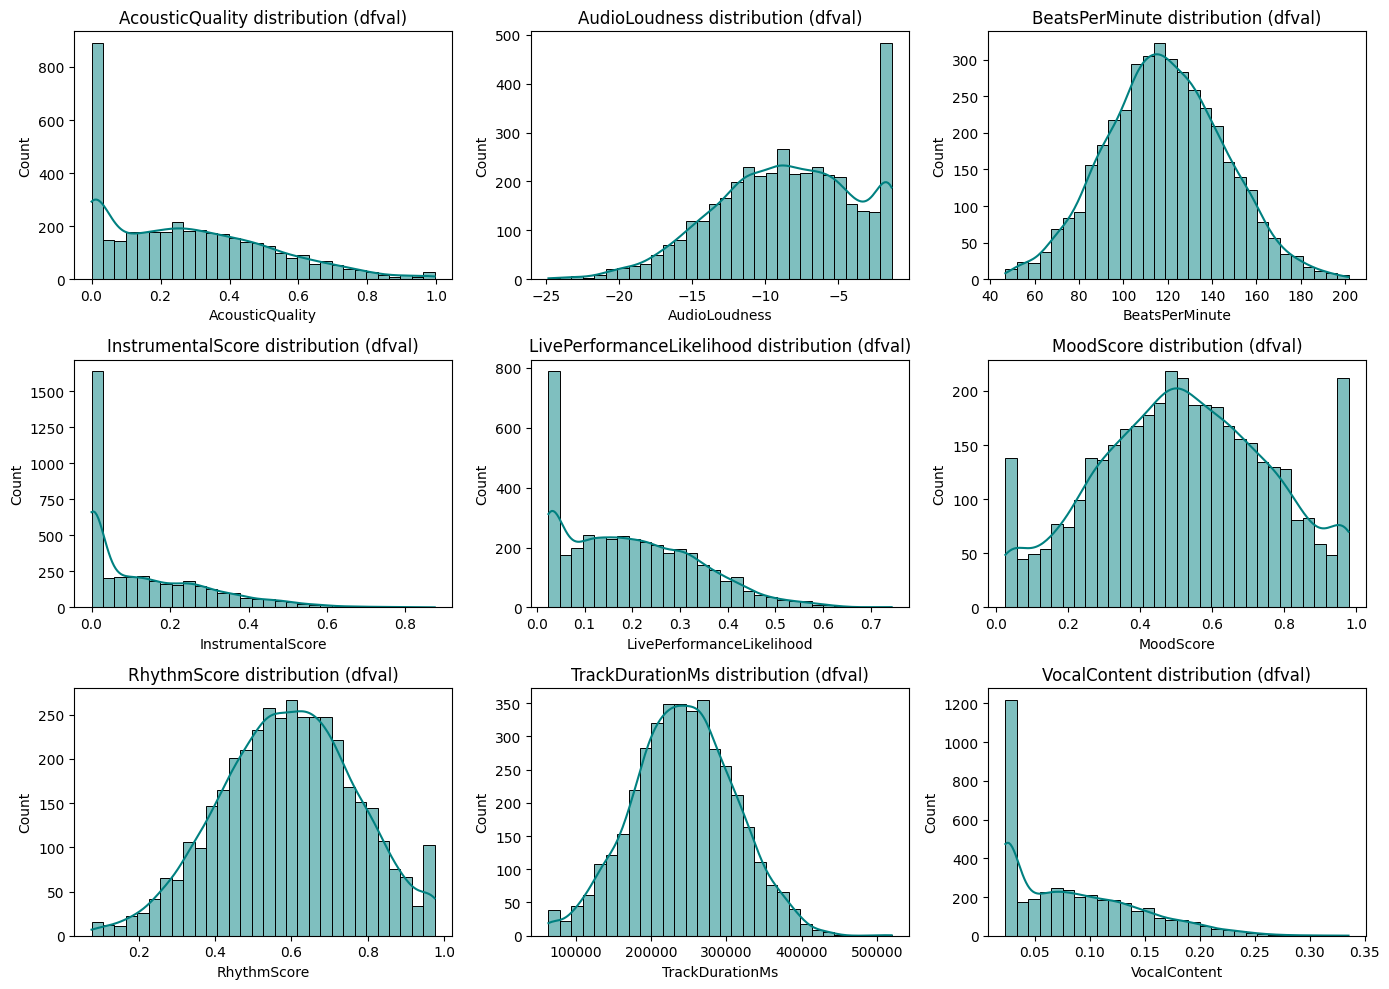

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
for i, col in enumerate(full_feats, 1):
    plt.subplot(3, 3, i)
    sns.histplot(dfval[col], kde=True, color="teal", bins=30)
    plt.title(f"{col} distribution (dfval)")
plt.tight_layout()
plt.show()


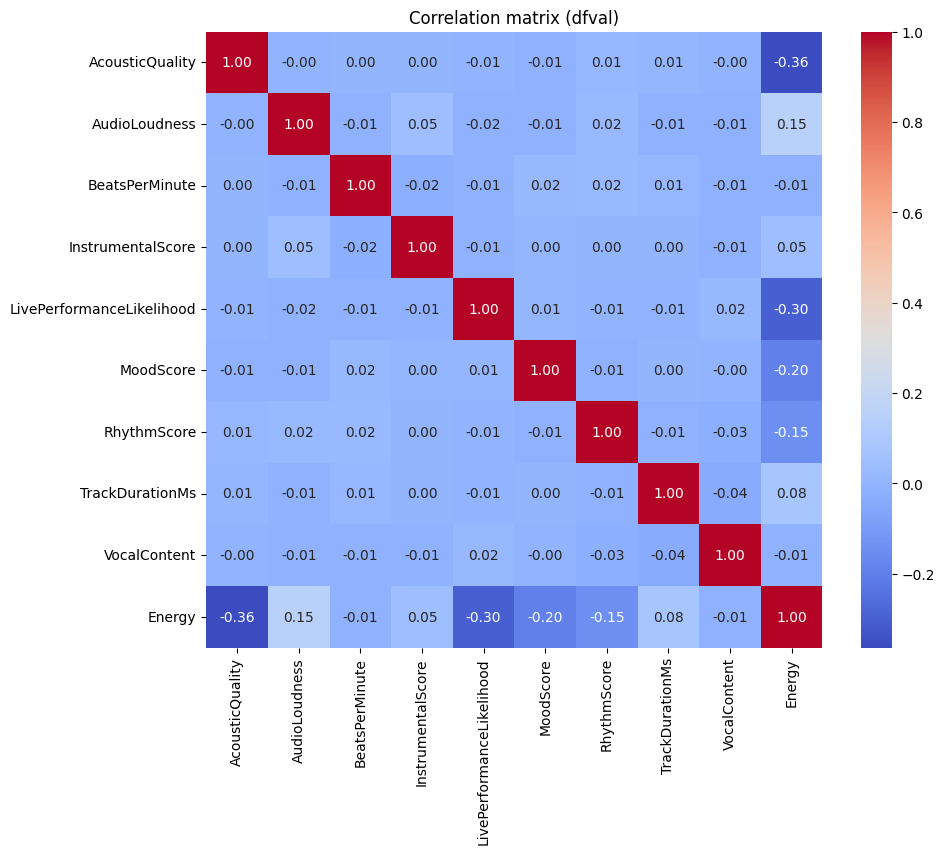

In [8]:
plt.figure(figsize=(10, 8))
corr = dfval[full_feats + [TARGET]].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", square=True)
plt.title("Correlation matrix (dfval)")
plt.show()


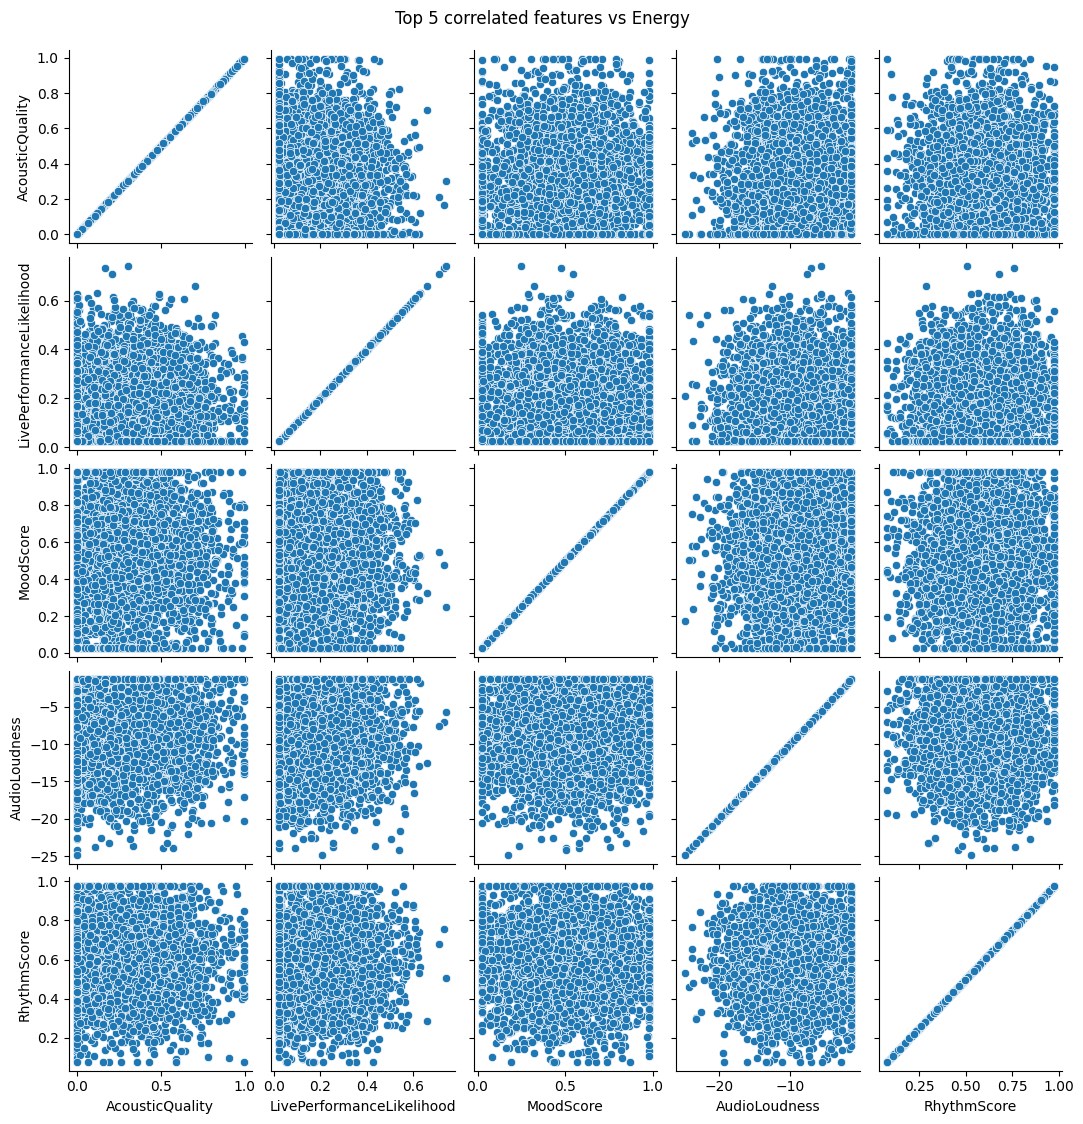

In [9]:
top_corrs = corr[TARGET].abs().sort_values(ascending=False)[1:6].index
sns.pairplot(dfval, vars=top_corrs, y_vars=[TARGET], kind="scatter", diag_kind=None, height=2.2)
plt.suptitle("Top 5 correlated features vs Energy", y=1.02)
plt.show()


## Strategy 0 — only use df1

In [10]:
# ==== [10] Strategy 0 — Ridge on common features ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_0_train, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for 0_Ridge:", gs.best_params_)

# Fit and evaluate
best.fit(X_0_train, y_0_train)
pred_tr = best.predict(X_0_train)
pred_val = best.predict(X_0_val)

RESULTS += [
    metrics(y_0_train, pred_tr, "0_Ridge | In-sample"),
    metrics(y_0_val,   pred_val, "0_Ridge | dfval"),
]
MODEL_STORE["0_Ridge"] = best
VAL_PRED_STORE["0_Ridge"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("0_Ridge")],
                    "Ridge (Strategy 0) metrics")

# Optional: write Xtest predictions
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("0_Ridge_Xtest.csv", index=False)

Best params for 0_Ridge: {'est__alpha': 10.0}

Ridge (Strategy 0) metrics
                         RMSE       MAE        R2
label                                            
0_Ridge | In-sample  0.279809  0.240991  0.016557
0_Ridge | dfval      0.289171  0.250500  0.021387


,RMSE,MAE,R2
label,,,
0_Ridge | In-sample,0.279809,0.240991,0.016557
0_Ridge | dfval,0.289171,0.250500,0.021387


In [11]:
# ==== [10] Strategy 0 — Ridge on common features ====
pipe = Pipeline([
    ("prep", polynomial_preproc(degree=2, interaction_only=False)),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_0_train, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for 0_Ridge_poly2:", gs.best_params_)

# Fit and evaluate
best.fit(X_0_train, y_0_train)
pred_tr = best.predict(X_0_train)
pred_val = best.predict(X_0_val)

RESULTS += [
    metrics(y_0_train, pred_tr, "0_Ridge_poly2 | In-sample"),
    metrics(y_0_val,   pred_val, "0_Ridge_poly2 | dfval"),
]
MODEL_STORE["0_Ridge_poly2"] = best
VAL_PRED_STORE["0_Ridge_poly2"] = pred_val

a = print_metrics_table([r for r in RESULTS if r["label"].startswith("0_Ridge_poly2")],
                    "Ridge (Strategy 0) metrics")

# Optional: write Xtest predictions
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("0_Ridge_Xtest.csv", index=False)

Best params for 0_Ridge_poly2: {'est__alpha': 10.0}

Ridge (Strategy 0) metrics
                               RMSE       MAE        R2
label                                                  
0_Ridge_poly2 | In-sample  0.277118  0.239569  0.035382
0_Ridge_poly2 | dfval      0.285638  0.247399  0.045155


In [12]:
# ==== [10] Strategy 0 — Lasso on common features ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Lasso(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {"est__alpha": [0.001, 0.01, 0.1, 1.0]}

gs = cv_grid_search(pipe, grid, X_0_train, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for 0_Lasso:", gs.best_params_)

best.fit(X_0_train, y_0_train)
pred_tr = best.predict(X_0_train)
pred_val = best.predict(X_0_val)

RESULTS += [
    metrics(y_0_train, pred_tr, "0_Lasso | In-sample"),
    metrics(y_0_val,   pred_val, "0_Lasso | dfval"),
]
MODEL_STORE["0_Lasso"] = best
VAL_PRED_STORE["0_Lasso"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("0_Lasso")],
                    "Lasso (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("0_Lasso_Xtest.csv", index=False)


Best params for 0_Lasso: {'est__alpha': 0.01}

Lasso (Strategy A) metrics
                         RMSE       MAE        R2
label                                            
0_Lasso | In-sample  0.280317  0.241951  0.012984
0_Lasso | dfval      0.289826  0.251341  0.016950


,RMSE,MAE,R2
label,,,
0_Lasso | In-sample,0.280317,0.241951,0.012984
0_Lasso | dfval,0.289826,0.251341,0.016950


In [13]:
# ==== [10] Strategy 0 — Elastic Net on common features ====
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)


X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)


pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_0_train_tf, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for 0_ElasticNet:", gs.best_params_)

best.fit(X_0_train_tf, y_0_train)
pred_tr = best.predict(X_0_train_tf)
pred_val = best.predict(X_0_val_tf)

RESULTS += [
    metrics(y_0_train, pred_tr, "0_ElasticNet | In-sample"),
    metrics(y_0_val,   pred_val, "0_ElasticNet | dfval"),
]
MODEL_STORE["0_ElasticNet"] = best
VAL_PRED_STORE["0_ElasticNet"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("0_ElasticNet")],
                    "Elastic Net (Strategy 0) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("0_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['InstrumentalScore']


Best params for 0_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.8}

Elastic Net (Strategy 0) metrics
                              RMSE       MAE        R2
label                                                 
0_ElasticNet | In-sample  0.280139  0.241709  0.014239
0_ElasticNet | dfval      0.289607  0.251119  0.018432


,RMSE,MAE,R2
label,,,
0_ElasticNet | In-sample,0.280139,0.241709,0.014239
0_ElasticNet | dfval,0.289607,0.251119,0.018432


In [14]:
# ==== [10] Strategy 0 — Elastic Net on df1 with poly2 ====
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)

pipe = Pipeline([
    ("prep", polynomial_preproc(degree=2, interaction_only=False)),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_0_train_tf, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for 0_ElasticNet_poly2:", gs.best_params_)

best.fit(X_0_train_tf, y_0_train)
pred_tr = best.predict(X_0_train_tf)
pred_val = best.predict(X_0_val_tf)

RESULTS += [
    metrics(y_0_train, pred_tr, "0_ElasticNet_poly2 | In-sample"),
    metrics(y_0_val,   pred_val, "0_ElasticNet_poly2 | dfval"),
]
MODEL_STORE["0_ElasticNet_poly2"] = best
VAL_PRED_STORE["0_ElasticNet_poly2"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("0_ElasticNet_poly2")],
                    "Elastic Net (Strategy 0) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("0_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['InstrumentalScore']
Best params for 0_ElasticNet_poly2: {'est__alpha': 0.01, 'est__l1_ratio': 0.8}

Elastic Net (Strategy 0) metrics
                                    RMSE       MAE        R2
label                                                       
0_ElasticNet_poly2 | In-sample  0.279551  0.241288  0.018373
0_ElasticNet_poly2 | dfval      0.289098  0.250670  0.021882


,RMSE,MAE,R2
label,,,
0_ElasticNet_poly2 | In-sample,0.279551,0.241288,0.018373
0_ElasticNet_poly2 | dfval,0.289098,0.250670,0.021882


In [15]:
# ==== [0D] Strategy 0 — Random Forest on df1 features ====
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

grid = {
    "est__n_estimators": [200],
    "est__max_depth": [None, 6, 10],
    "est__min_samples_leaf": [1, 3, 5]
}

gs = cv_grid_search(pipe, grid, X_0_train, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for 0_RF:", gs.best_params_)

best.fit(X_0_train, y_0_train)
pred_tr = best.predict(X_0_train)
pred_val = best.predict(X_0_val)

RESULTS += [
    metrics(y_0_train, pred_tr, "0_RF | In-sample"),
    metrics(y_0_val,   pred_val, "0_RF | dfval"),
]
MODEL_STORE["0_RF"] = best
VAL_PRED_STORE["0_RF"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("0_RF")],
                    "Random Forest (Strategy 0) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("0_RF_Xtest.csv", index=False)


Best params for 0_RF: {'est__max_depth': 6, 'est__min_samples_leaf': 1, 'est__n_estimators': 200}

Random Forest (Strategy 0) metrics
                      RMSE       MAE        R2
label                                         
0_RF | In-sample  0.233766  0.202172  0.313583
0_RF | dfval      0.285490  0.245130  0.046139


,RMSE,MAE,R2
label,,,
0_RF | In-sample,0.233766,0.202172,0.313583
0_RF | dfval,0.285490,0.245130,0.046139


In [16]:
# ==== [0E] Strategy 0 — HistGradientBoosting on common features ====
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 6],
    "est__min_samples_leaf": [20, 50],
    "est__learning_rate": [0.05, 0.1],
}

gs = cv_grid_search(pipe, grid, X_0_train, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for 0_HGB:", gs.best_params_)

best.fit(X_0_train, y_0_train)
pred_tr = best.predict(X_0_train)
pred_val = best.predict(X_0_val)

RESULTS += [
    metrics(y_0_train, pred_tr, "0_HGB | In-sample"),
    metrics(y_0_val,   pred_val, "0_HGB | dfval"),
]
MODEL_STORE["0_HGB"] = best
VAL_PRED_STORE["0_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("0_HGB")],
                    "HistGradientBoosting (Strategy 0) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("0_HGB_Xtest.csv", index=False)


Best params for 0_HGB: {'est__learning_rate': 0.05, 'est__max_depth': 6, 'est__min_samples_leaf': 50}

HistGradientBoosting (Strategy 0) metrics
                       RMSE       MAE        R2
label                                          
0_HGB | In-sample  0.242023  0.207577  0.264237
0_HGB | dfval      0.283834  0.242548  0.057176


,RMSE,MAE,R2
label,,,
0_HGB | In-sample,0.242023,0.207577,0.264237
0_HGB | dfval,0.283834,0.242548,0.057176


In [17]:
# === XGBoost implementations for Strategy 0 (only on df1) with GridSearch
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.6)

# ----------------- Strategy 0: XGB on common_feats with GridSearch -----------------
X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)

# Grid-search XGBoost hyperparameters for Strategy 0
xgb_base_0 = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

param_grid_a = {
    "learning_rate": [0.02, 0.03],
    "max_depth": [2, 3, 4],
    "min_child_weight": [2, 3],
    "gamma": [0, 0.25],                # was off; add light split penalty
    "subsample": [0.6, 0.7, 0.8],           # let full sampling be an option
    "colsample_bytree": [0.7, 0.8],    # allow full column use (only 4 feats)
    "reg_lambda": [0.1, 1],
    "reg_alpha": [0, 0.1],
}

print("Running GridSearchCV for 0_XGB (this may take a while)...")
gs_0 = cv_grid_search(xgb_base_0, param_grid_a, X_0_train_tf, y_0_train, splits=5)
best_xgb_0 = gs_0.best_estimator_
print("Best params (0_XGB):", gs_0.best_params_)

# Ensure fitted and evaluate
best_xgb_0.fit(X_0_train_tf, y_0_train)
pred_tr_0 = best_xgb_0.predict(X_0_train_tf)
pred_val_0 = best_xgb_0.predict(X_0_val_tf)

# Remove any existing 0_XGB entries and add new ones
incoming_0 = {"0_XGB | In-sample", "0_XGB | dfval", "0_XGB | In-sample", "0_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_0]
RESULTS += [
    metrics(y_0_train, pred_tr_0, "0_XGB | In-sample"),
    metrics(y_0_val,   pred_val_0, "0_XGB | dfval"),
]
MODEL_STORE["0_XGB"] = best_xgb_0
VAL_PRED_STORE["0_XGB"] = pred_val_0

print_metrics_table([r for r in RESULTS if r["label"].startswith("0_XGB")],
                    "XGBoost (Strategy 0) metrics")

Running GridSearchCV for 0_XGB (this may take a while)...
Best params (0_XGB): {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7}

XGBoost (Strategy 0) metrics
                       RMSE       MAE        R2
label                                          
0_XGB | In-sample  0.261644  0.226602  0.140103
0_XGB | dfval      0.284758  0.245804  0.051030


,RMSE,MAE,R2
label,,,
0_XGB | In-sample,0.261644,0.226602,0.140103
0_XGB | dfval,0.284758,0.245804,0.051030


In [18]:
# === XGBoost implementations for Strategy 0 (only on df1) no GridSearch (updated to reuse GridSearch result if available)
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.6)

# Transformed inputs (log1p on detected skewed cols)
X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)

# If GridSearchCV produced best_xgb_0, reuse it (it's already fitted on X_0_train_tf).
# Otherwise, build an XGBRegressor with the best params discovered and fit it on the transformed data.
if "best_xgb_0" in globals():
    print("Reusing best_xgb_0 from earlier GridSearchCV (assumed fitted).")
    model_0_xgb = best_xgb_0
else:
    print("No GridSearch result found; instantiating XGBRegressor with chosen best params and fitting.")
    model_0_xgb = XGBRegressor(
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0,
        colsample_bytree=0.8,
        gamma=0,
        learning_rate=0.02,
        max_depth=3,
        min_child_weight=2,
        reg_alpha=0,
        reg_lambda=0.1,
        subsample=0.7,
        n_estimators=700,
    )
    model_0_xgb.fit(X_0_train_tf, y_0_train)

# Predict on train/val (use the same transformed matrices)
pred_tr_0 = model_0_xgb.predict(X_0_train_tf)
pred_val_0 = model_0_xgb.predict(X_0_val_tf)

# Replace any existing 0_XGB results and store estimator
incoming_0 = {"0_XGB | In-sample", "0_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_0]
RESULTS += [
    metrics(y_0_train, pred_tr_0, "0_XGB | In-sample"),
    metrics(y_0_val,   pred_val_0, "0_XGB | dfval"),
]
MODEL_STORE["0_XGB"] = model_0_xgb
VAL_PRED_STORE["0_XGB"] = pred_val_0

print("Best params used:", {
    'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02,
    'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0,
    'reg_lambda': 0.1, 'subsample': 0.7, 'n_estimators': 700
})

print_metrics_table([r for r in RESULTS if r["label"].startswith("0_XGB")],
                    "XGBoost (Strategy 0) - Best Params")

Reusing best_xgb_0 from earlier GridSearchCV (assumed fitted).
Best params used: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7, 'n_estimators': 700}

XGBoost (Strategy 0) - Best Params
                       RMSE       MAE        R2
label                                          
0_XGB | In-sample  0.261644  0.226602  0.140103
0_XGB | dfval      0.284758  0.245804  0.051030


,RMSE,MAE,R2
label,,,
0_XGB | In-sample,0.261644,0.226602,0.140103
0_XGB | dfval,0.284758,0.245804,0.051030


In [19]:
# print all results starting with 0_
a = print_metrics_table([r for r in RESULTS if r["label"].startswith("0_")],
                    "All Strategy 0 results")


All Strategy 0 results
                                    RMSE       MAE        R2
label                                                       
0_RF | In-sample                0.233766  0.202172  0.313583
0_HGB | In-sample               0.242023  0.207577  0.264237
0_XGB | In-sample               0.261644  0.226602  0.140103
0_Ridge_poly2 | In-sample       0.277118  0.239569  0.035382
0_ElasticNet_poly2 | In-sample  0.279551  0.241288  0.018373
0_Ridge | In-sample             0.279809  0.240991  0.016557
0_ElasticNet | In-sample        0.280139  0.241709  0.014239
0_Lasso | In-sample             0.280317  0.241951  0.012984
0_HGB | dfval                   0.283834  0.242548  0.057176
0_XGB | dfval                   0.284758  0.245804  0.051030
0_RF | dfval                    0.285490  0.245130  0.046139
0_Ridge_poly2 | dfval           0.285638  0.247399  0.045155
0_ElasticNet_poly2 | dfval      0.289098  0.250670  0.021882
0_Ridge | dfval                 0.289171  0.250500  0.021387


In [20]:
# === [NEW] Strategy-0 Ensemble: Modular Implementation ====

from sklearn.linear_model import LinearRegression

def get_strategy0_candidates(results, top_k=3, rmse_close_abs=0.02, rmse_close_rel=0.05):
    """
    Extract and rank Strategy-0 models by dfval RMSE.
    
    Returns:
        list: Selected model names for ensemble
        str: Reason for selection
        list: All candidates with (name, rmse) tuples
    """
    dfval_rows = [r for r in results if r.get("label", "").endswith("| dfval")]
    rows0 = [r for r in dfval_rows if r["label"].startswith("0_")]
    
    if not rows0:
        return [], "No Strategy-0 dfval results found", []
    
    # Extract (name, rmse) and sort by RMSE
    rmse_list = []
    for r in rows0:
        name = r["label"].split(" | ")[0]
        rmse = float(r["RMSE"])
        rmse_list.append((name, rmse))
    
    rmse_list = sorted(rmse_list, key=lambda x: x[1])
    top_candidates = rmse_list[:top_k]
    names_top = [n for n, _ in top_candidates]
    rmse_vals = [v for _, v in top_candidates]
    
    # Decide selection strategy
    if len(rmse_vals) >= 3:
        diff = rmse_vals[-1] - rmse_vals[0]
        threshold = max(rmse_close_abs, rmse_close_rel * rmse_vals[0])
        if diff <= threshold:
            keep_names = names_top
            reason = f"kept top {len(names_top)} because diff {diff:.4f} <= threshold {threshold:.4f}"
        else:
            keep_names = [names_top[0]]
            reason = f"kept only best because diff {diff:.4f} > threshold {threshold:.4f}"
    else:
        keep_names = names_top
        reason = f"kept {len(names_top)} available candidate(s)"
    
    return keep_names, reason, rmse_list

def create_strategy0_predictor(model_store, candidate_feats, skewed_cols):
    """
    Create a unified predictor function for Strategy-0 models.
    Handles different model types (XGB with transforms, pipelines, etc.)
    """
    def predict_0_on(df, model_name):
        mdl = model_store.get(model_name)
        if mdl is None:
            raise KeyError(f"Model {model_name} not found in MODEL_STORE")
        
        # Special handling for XGB models that need log transformation
        if model_name == "0_XGB" and isinstance(mdl, XGBRegressor):
            X = apply_log1p(df[candidate_feats], skewed_cols)
            return mdl.predict(X)
        else:
            # Standard pipelines/estimators
            return mdl.predict(df[candidate_feats])
    
    return predict_0_on

def build_prediction_matrices(model_names, predictor_fn, dfval, df2, val_pred_store):
    """
    Build prediction matrices for ensemble learning and application.
    
    Returns:
        np.array: Validation predictions (n_val, n_models)
        np.array: df2 predictions (n_df2, n_models)
        list: Valid model names (after filtering NaN columns)
    """
    Z_val_list = []
    Z_df2_list = []
    
    for nm in model_names:
        # Try to reuse cached validation predictions
        val_pred = val_pred_store.get(nm)
        if val_pred is None:
            try:
                val_pred = predictor_fn(dfval, nm)
            except Exception as e:
                print(f"Warning: failed to get dfval preds for {nm}: {e}")
                val_pred = np.full(len(dfval), np.nan)
        Z_val_list.append(val_pred)
        
        # Generate df2 predictions
        try:
            p2 = predictor_fn(df2, nm)
        except Exception as e:
            print(f"Warning: failed to get df2 preds for {nm}: {e}")
            p2 = np.full(len(df2), np.nan)
        Z_df2_list.append(p2)
    
    Z_val = np.vstack(Z_val_list).T  # (n_val, n_models)
    Z_df2 = np.vstack(Z_df2_list).T  # (n_df2, n_models)
    
    # Filter out models with all-NaN predictions
    valid_cols = ~np.all(np.isnan(Z_val), axis=0)
    if not np.all(valid_cols):
        dropped = [nm for nm, ok in zip(model_names, valid_cols) if not ok]
        print(f"Dropping models with invalid dfval predictions: {dropped}")
        Z_val = Z_val[:, valid_cols]
        Z_df2 = Z_df2[:, valid_cols]
        model_names = [nm for nm, ok in zip(model_names, valid_cols) if ok]
    
    return Z_val, Z_df2, model_names

def learn_ensemble_weights(Z_val, y_val):
    """
    Learn non-negative linear weights for ensemble on validation data.
    
    Returns:
        fitted blender model
        dict: weights per model
        float: intercept
    """
    try:
        blender = LinearRegression(positive=True)
    except TypeError:
        blender = LinearRegression()  # fallback for older sklearn
    
    blender.fit(Z_val, y_val)
    
    weights = blender.coef_.tolist()
    intercept = float(getattr(blender, "intercept_", 0.0))
    
    return blender, weights, intercept

def add_ensemble_features_to_df2(df2, Z_df2, model_names, ensemble_preds):
    """
    Add individual model predictions and ensemble prediction as new features to df2.
    
    Returns:
        pd.DataFrame: df2 with new prediction columns
    """
    df2_copy = df2.copy()
    
    # # Add individual model predictions
    # for i, nm in enumerate(model_names):
    #     df2_copy[f"pred_from_{nm}"] = Z_df2[:, i]
    
    # Add ensemble prediction
    df2_copy["pred_from_df1_ensemble"] = ensemble_preds
    
    return df2_copy

def store_ensemble_metadata(model_store, val_pred_store, model_names, blender, 
                          val_ensemble_preds, df2_ensemble_preds):
    """Store ensemble metadata and predictions for later use."""
    # Update validation prediction store
    val_pred_store["0_ENSEMBLE_on_dfval"] = val_ensemble_preds
    val_pred_store["0_ENSEMBLE_on_df2"] = df2_ensemble_preds
    
    # Store ensemble model metadata
    model_store["0_ENSEMBLE"] = {
        "members": model_names,
        "blender": blender,
        "type": "learned_on_dfval"
    }

# === Main execution ===
def create_strategy0_ensemble():
    """Main function to create Strategy-0 ensemble and add features to df2."""
    global df2  # Declare global at the very beginning
    
    # Step 1: Get candidate models
    keep_names, reason, rmse_list = get_strategy0_candidates(
        RESULTS, top_k=3, rmse_close_abs=0.02, rmse_close_rel=0.05
    )
    
    if not keep_names:
        print("No Strategy-0 dfval results found; nothing to add to df2.")
        return
    
    print(f"Strategy-0 candidates (RMSE sorted): {rmse_list}")
    print(f"Selected 0_ members: {keep_names} | {reason}")
    
    # Step 2: Set up predictor function
    candidate_feats_0 = features_df1
    skewed_cols_0 = detect_skewed_cols(df1, candidate_feats_0, thresh=0.6)
    predictor_fn = create_strategy0_predictor(MODEL_STORE, candidate_feats_0, skewed_cols_0)
    
    # Step 3: Build prediction matrices
    Z_val, Z_df2, valid_names = build_prediction_matrices(
        keep_names, predictor_fn, dfval, df2, VAL_PRED_STORE
    )
    
    if len(valid_names) == 0:
        print("No valid models remaining after filtering; ensemble creation failed.")
        return
    
    # Step 4: Learn ensemble weights
    y_val = dfval[TARGET].values
    blender, weights, intercept = learn_ensemble_weights(Z_val, y_val)
    
    print(f"Learned (non-negative) weights on dfval for 0_ members: {dict(zip(valid_names, weights))}")
    print(f"Intercept: {intercept}")
    
    # Step 5: Generate ensemble predictions
    ensemble_on_df2 = blender.predict(Z_df2)
    ensemble_on_val = blender.predict(Z_val)
    
    # === NEW: Report ensemble validation accuracy ===
    ensemble_val_metrics = metrics(y_val, ensemble_on_val, "0_ENSEMBLE | dfval")
    print(f"\nEnsemble validation accuracy:")
    print(f"  RMSE: {ensemble_val_metrics['RMSE']:.4f}")
    print(f"  MAE:  {ensemble_val_metrics['MAE']:.4f}")
    print(f"  R²:   {ensemble_val_metrics['R2']:.4f}")
    
    # Step 6: Add features to df2
    df2_aug = add_ensemble_features_to_df2(df2, Z_df2, valid_names, ensemble_on_df2)
    
    # Step 7: Store metadata
    store_ensemble_metadata(
        MODEL_STORE, VAL_PRED_STORE, valid_names, blender,
        ensemble_on_val, ensemble_on_df2
    )
    
    print(f"Appended {len(valid_names)} Strategy-0 prediction columns + ensemble to df2 (shape {df2_aug.shape}).")
    
    return df2_aug

# Execute the ensemble creation
df2_aug = create_strategy0_ensemble()

Strategy-0 candidates (RMSE sorted): [('0_HGB', 0.28383392997868057), ('0_XGB', 0.28475755289071986), ('0_RF', 0.2854904955845153), ('0_Ridge_poly2', 0.28563767212228763), ('0_ElasticNet_poly2', 0.289097763128505), ('0_Ridge', 0.28917079448698063), ('0_ElasticNet', 0.28960707739777736), ('0_Lasso', 0.28982572276358853)]
Selected 0_ members: ['0_HGB', '0_XGB', '0_RF'] | kept top 3 because diff 0.0017 <= threshold 0.0200
Learned (non-negative) weights on dfval for 0_ members: {'0_HGB': 0.5246469943258346, '0_XGB': 0.6736213860143762, '0_RF': 0.0}
Intercept: -0.10214984643024139

Ensemble validation accuracy:
  RMSE: 0.2826
  MAE:  0.2424
  R²:   0.0653
Appended 3 Strategy-0 prediction columns + ensemble to df2 (shape (50, 11)).


In [21]:
display(df2_aug.head())

,AudioLoudness,VocalContent,InstrumentalScore,TrackDurationMs,MoodScore,LivePerformanceLikelihood,RhythmScore,BeatsPerMinute,AcousticQuality,Energy,pred_from_df1_ensemble
0,-11.440931,0.023500,0.033187,248690.96540,0.450407,0.175127,0.588774,118.939062,0.000005,1.000000,0.479586
1,-11.615412,0.161318,0.000001,306581.75890,0.226243,0.235302,0.326847,65.839092,0.000005,0.730743,0.477879
2,-1.704469,0.037208,0.000001,348110.23450,0.193083,0.189641,0.642252,144.518693,0.557669,0.745158,0.540386
3,-8.194718,0.071638,0.731908,83526.05152,0.676062,0.277297,0.534640,117.038385,0.159250,0.461324,0.466643
4,-7.979415,0.023500,0.000001,159770.45340,0.881021,0.395619,0.544520,110.438965,0.099547,0.612047,0.400368


## Strategy A — Common features

In [22]:
# ==== [1A] Strategy A — Ridge on common features ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_A_train, y_A_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_Ridge:", gs.best_params_)

# Fit and evaluate
best.fit(X_A_train, y_A_train)
pred_tr = best.predict(X_A_train)
pred_val = best.predict(X_A_val)

RESULTS += [
    metrics(y_A_train, pred_tr, "A_Ridge | In-sample"),
    metrics(y_A_val,   pred_val, "A_Ridge | dfval"),
]
MODEL_STORE["A_Ridge"] = best
VAL_PRED_STORE["A_Ridge"] = pred_val

a = print_metrics_table([r for r in RESULTS if r["label"].startswith("A_Ridge")],
                    "Ridge (Strategy A) metrics")

# Optional: write Xtest predictions
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_Ridge_Xtest.csv", index=False)

Best params for A_Ridge: {'est__alpha': 10.0}

Ridge (Strategy A) metrics
                         RMSE       MAE        R2
label                                            
A_Ridge | In-sample  0.280837  0.241595  0.020102
A_Ridge | dfval      0.288830  0.250225  0.023690


In [23]:
# ==== [1A] Strategy A — Ridge on common features ====
pipe = Pipeline([
    ("prep", polynomial_preproc(degree=2, interaction_only=False)),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_A_train, y_A_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_Ridge_poly2:", gs.best_params_)

# Fit and evaluate
best.fit(X_A_train, y_A_train)
pred_tr = best.predict(X_A_train)
pred_val = best.predict(X_A_val)

RESULTS += [
    metrics(y_A_train, pred_tr, "A_Ridge_poly2 | In-sample"),
    metrics(y_A_val,   pred_val, "A_Ridge_poly2 | dfval"),
]
MODEL_STORE["A_Ridge_poly2"] = best
VAL_PRED_STORE["A_Ridge_poly2"] = pred_val

a = print_metrics_table([r for r in RESULTS if r["label"].startswith("A_Ridge_poly2")],
                    "Ridge (Strategy A) metrics")

# Optional: write Xtest predictions
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_Ridge_Xtest.csv", index=False)

Best params for A_Ridge_poly2: {'est__alpha': 10.0}

Ridge (Strategy A) metrics
                               RMSE       MAE        R2
label                                                  
A_Ridge_poly2 | In-sample  0.278201  0.240386  0.038416
A_Ridge_poly2 | dfval      0.285220  0.247041  0.047944


In [24]:
# ==== [1B] Strategy A — Lasso on common features ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Lasso(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {"est__alpha": [0.001, 0.01, 0.1, 1.0]}

gs = cv_grid_search(pipe, grid, X_A_train, y_A_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_Lasso:", gs.best_params_)

best.fit(X_A_train, y_A_train)
pred_tr = best.predict(X_A_train)
pred_val = best.predict(X_A_val)

RESULTS += [
    metrics(y_A_train, pred_tr, "A_Lasso | In-sample"),
    metrics(y_A_val,   pred_val, "A_Lasso | dfval"),
]
MODEL_STORE["A_Lasso"] = best
VAL_PRED_STORE["A_Lasso"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_Lasso")],
                    "Lasso (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_Lasso_Xtest.csv", index=False)


Best params for A_Lasso: {'est__alpha': 0.001}

Lasso (Strategy A) metrics
                         RMSE       MAE        R2
label                                            
A_Lasso | In-sample  0.280844  0.241653  0.020059
A_Lasso | dfval      0.288793  0.250230  0.023943


,RMSE,MAE,R2
label,,,
A_Lasso | In-sample,0.280844,0.241653,0.020059
A_Lasso | dfval,0.288793,0.250230,0.023943


In [25]:
# ==== [1C] Strategy A — Elastic Net on common features ====
candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)


pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_A_train, y_A_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_ElasticNet:", gs.best_params_)

best.fit(X_A_train, y_A_train)
pred_tr = best.predict(X_A_train)
pred_val = best.predict(X_A_val)

RESULTS += [
    metrics(y_A_train, pred_tr, "A_ElasticNet | In-sample"),
    metrics(y_A_val,   pred_val, "A_ElasticNet | dfval"),
]
MODEL_STORE["A_ElasticNet"] = best
VAL_PRED_STORE["A_ElasticNet"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_ElasticNet")],
                    "Elastic Net (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Best params for A_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.2}

Elastic Net (Strategy A) metrics
                              RMSE       MAE        R2
label                                                 
A_ElasticNet | In-sample  0.280866  0.241737  0.019901
A_ElasticNet | dfval      0.288788  0.250272  0.023974


,RMSE,MAE,R2
label,,,
A_ElasticNet | In-sample,0.280866,0.241737,0.019901
A_ElasticNet | dfval,0.288788,0.250272,0.023974


In [26]:
# ==== [1C] Strategy A — Elastic Net on common features ====
candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)

pipe = Pipeline([
    ("prep", polynomial_preproc(degree=2, interaction_only=False)),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_A_train_tf, y_A_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_ElasticNet_poly2:", gs.best_params_)

best.fit(X_A_train_tf, y_A_train)
pred_tr = best.predict(X_A_train_tf)
pred_val = best.predict(X_A_val_tf)

RESULTS += [
    metrics(y_A_train, pred_tr, "A_ElasticNet_poly2 | In-sample"),
    metrics(y_A_val,   pred_val, "A_ElasticNet_poly2 | dfval"),
]
MODEL_STORE["A_ElasticNet_poly2"] = best
VAL_PRED_STORE["A_ElasticNet_poly2"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_ElasticNet_poly2")],
                    "Elastic Net (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Best params for A_ElasticNet_poly2: {'est__alpha': 0.01, 'est__l1_ratio': 0.2}

Elastic Net (Strategy A) metrics
                                  RMSE       MAE        R2
label                                                     
A_ElasticNet_poly2 | In-sample  0.2792  0.241023  0.031494
A_ElasticNet_poly2 | dfval      0.2868  0.248528  0.037368


,RMSE,MAE,R2
label,,,
A_ElasticNet_poly2 | In-sample,0.2792,0.241023,0.031494
A_ElasticNet_poly2 | dfval,0.2868,0.248528,0.037368


In [27]:
# ==== [1D] Strategy A — Random Forest on common features ====
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

grid = {
    "est__n_estimators": [200],
    "est__max_depth": [None, 6, 10],
    "est__min_samples_leaf": [1, 3, 5]
}

gs = cv_grid_search(pipe, grid, X_A_train, y_A_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_RF:", gs.best_params_)

best.fit(X_A_train, y_A_train)
pred_tr = best.predict(X_A_train)
pred_val = best.predict(X_A_val)

RESULTS += [
    metrics(y_A_train, pred_tr, "A_RF | In-sample"),
    metrics(y_A_val,   pred_val, "A_RF | dfval"),
]
MODEL_STORE["A_RF"] = best
VAL_PRED_STORE["A_RF"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_RF")],
                    "Random Forest (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_RF_Xtest.csv", index=False)


Best params for A_RF: {'est__max_depth': 6, 'est__min_samples_leaf': 3, 'est__n_estimators': 200}

Random Forest (Strategy A) metrics
                      RMSE       MAE        R2
label                                         
A_RF | In-sample  0.238242  0.205192  0.294810
A_RF | dfval      0.284273  0.244386  0.054257


,RMSE,MAE,R2
label,,,
A_RF | In-sample,0.238242,0.205192,0.294810
A_RF | dfval,0.284273,0.244386,0.054257


In [28]:
# ==== [1E] Strategy A — HistGradientBoosting on common features ====
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 6],
    "est__min_samples_leaf": [20, 50],
    "est__learning_rate": [0.05, 0.1],
}

gs = cv_grid_search(pipe, grid, X_A_train, y_A_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_HGB:", gs.best_params_)

best.fit(X_A_train, y_A_train)
pred_tr = best.predict(X_A_train)
pred_val = best.predict(X_A_val)

RESULTS += [
    metrics(y_A_train, pred_tr, "A_HGB | In-sample"),
    metrics(y_A_val,   pred_val, "A_HGB | dfval"),
]
MODEL_STORE["A_HGB"] = best
VAL_PRED_STORE["A_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_HGB")],
                    "HistGradientBoosting (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_HGB_Xtest.csv", index=False)


Best params for A_HGB: {'est__learning_rate': 0.05, 'est__max_depth': 6, 'est__min_samples_leaf': 50}

HistGradientBoosting (Strategy A) metrics
                       RMSE       MAE        R2
label                                          
A_HGB | In-sample  0.242255  0.207563  0.270854
A_HGB | dfval      0.284231  0.243286  0.054534


,RMSE,MAE,R2
label,,,
A_HGB | In-sample,0.242255,0.207563,0.270854
A_HGB | dfval,0.284231,0.243286,0.054534


In [29]:
# # === XGBoost implementations for Strategy A (common_feats) with GridSearch
# # candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
# # SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.6)

# SKEWED_COLS = []

# # ----------------- Strategy A: XGB on common_feats with GridSearch -----------------
# X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
# X_A_val_local   = dfval[common_feats]
# y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
# y_A_val_local   = dfval[TARGET]

# X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
# X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)

# # Grid-search XGBoost hyperparameters for Strategy A
# xgb_base_a = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

# param_grid_a = {
#     "learning_rate": [0.02, 0.03, 0.05],
#     "max_depth": [2, 3, 4],
#     "min_child_weight": [2, 3, 4],
#     "gamma": [0, 0.25, 0.5],                # was off; add light split penalty
#     "subsample": [0.6, 0.7, 0.8],           # let full sampling be an option
#     "colsample_bytree": [0.7, 0.8, 1.0],    # allow full column use (only 4 feats)
#     "reg_lambda": [0.1, 1, 5],
#     "reg_alpha": [0, 0.1, 0.25, 0.5],
# }

# print("Running GridSearchCV for A_XGB (this may take a while)...")
# gs_a = cv_grid_search(xgb_base_a, param_grid_a, X_A_train_tf, y_A_train_local, splits=5)
# best_xgb_a = gs_a.best_estimator_
# print("Best params (A_XGB):", gs_a.best_params_)

# # Ensure fitted and evaluate
# best_xgb_a.fit(X_A_train_tf, y_A_train_local)
# pred_tr_a = best_xgb_a.predict(X_A_train_tf)
# pred_val_a = best_xgb_a.predict(X_A_val_tf)

# # Remove any existing A_XGB entries and add new ones
# incoming_a = {"A_XGB | In-sample", "A_XGB | dfval", "A_XGB | In-sample", "A_XGB | dfval"}
# RESULTS = [r for r in RESULTS if r.get("label") not in incoming_a]
# RESULTS += [
#     metrics(y_A_train_local, pred_tr_a, "A_XGB | In-sample"),
#     metrics(y_A_val_local,   pred_val_a, "A_XGB | dfval"),
# ]
# MODEL_STORE["A_XGB"] = best_xgb_a
# VAL_PRED_STORE["A_XGB"] = pred_val_a

# print_metrics_table([r for r in RESULTS if r["label"].startswith("A_XGB")],
#                     "XGBoost (Strategy A) metrics")

In [30]:
# === XGBoost Strategy A with BEST PARAMS (no grid search) ===
SKEWED_COLS = []

# ----------------- Strategy A: XGB on common_feats with BEST PARAMS -----------------
X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)

# Use tree_preproc() (median imputer) in a Pipeline for deterministic NA handling
pipe = Pipeline([
    ("prep", tree_preproc()),   # median impute
    ("est", XGBRegressor(
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0,
        # Best parameters from your grid-search
        colsample_bytree=1.0,
        gamma=0,
        learning_rate=0.03,
        max_depth=2,
        min_child_weight=3,
        reg_alpha=0,
        reg_lambda=0.1,
        subsample=0.8,
    ))
])

print("Training A_XGB pipeline with best parameters (no grid search)...")
pipe.fit(X_A_train_tf, y_A_train_local)
pred_tr_a = pipe.predict(X_A_train_tf)
pred_val_a = pipe.predict(X_A_val_tf)

# Replace any existing A_XGB results and store pipeline
incoming_a = {"A_XGB | In-sample", "A_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_a]
RESULTS += [
    metrics(y_A_train_local, pred_tr_a, "A_XGB | In-sample"),
    metrics(y_A_val_local,   pred_val_a, "A_XGB | dfval"),
]
MODEL_STORE["A_XGB"] = pipe
VAL_PRED_STORE["A_XGB"] = pred_val_a

print("Best params used:", {
    'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03,
    'max_depth': 2, 'min_child_weight': 3, 'reg_alpha': 0,
    'reg_lambda': 0.1, 'subsample': 0.8, 'n_estimators': 700
})

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_XGB")],
                    "XGBoost (Strategy A) - Best Params")

Training A_XGB pipeline with best parameters (no grid search)...
Best params used: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8, 'n_estimators': 700}

XGBoost (Strategy A) - Best Params
                       RMSE       MAE        R2
label                                          
A_XGB | In-sample  0.268637  0.232371  0.103392
A_XGB | dfval      0.284514  0.245789  0.052655


,RMSE,MAE,R2
label,,,
A_XGB | In-sample,0.268637,0.232371,0.103392
A_XGB | dfval,0.284514,0.245789,0.052655


In [31]:
# Print all results starting with A_
a = print_metrics_table([r for r in RESULTS if r["label"].startswith("A_")],
                    "All Strategy A results")

# sort by R2
a = a.sort_values("R2", ascending=False)
display(a)


All Strategy A results
                                    RMSE       MAE        R2
label                                                       
A_RF | In-sample                0.238242  0.205192  0.294810
A_HGB | In-sample               0.242255  0.207563  0.270854
A_XGB | In-sample               0.268637  0.232371  0.103392
A_Ridge_poly2 | In-sample       0.278201  0.240386  0.038416
A_ElasticNet_poly2 | In-sample  0.279200  0.241023  0.031494
A_Ridge | In-sample             0.280837  0.241595  0.020102
A_Lasso | In-sample             0.280844  0.241653  0.020059
A_ElasticNet | In-sample        0.280866  0.241737  0.019901
A_HGB | dfval                   0.284231  0.243286  0.054534
A_RF | dfval                    0.284273  0.244386  0.054257
A_XGB | dfval                   0.284514  0.245789  0.052655
A_Ridge_poly2 | dfval           0.285220  0.247041  0.047944
A_ElasticNet_poly2 | dfval      0.286800  0.248528  0.037368
A_ElasticNet | dfval            0.288788  0.250272  0.023974


,RMSE,MAE,R2
label,,,
A_RF | In-sample,0.238242,0.205192,0.294810
A_HGB | In-sample,0.242255,0.207563,0.270854
A_XGB | In-sample,0.268637,0.232371,0.103392
A_HGB | dfval,0.284231,0.243286,0.054534
A_RF | dfval,0.284273,0.244386,0.054257
A_XGB | dfval,0.284514,0.245789,0.052655
A_Ridge_poly2 | dfval,0.285220,0.247041,0.047944
A_Ridge_poly2 | In-sample,0.278201,0.240386,0.038416
A_ElasticNet_poly2 | dfval,0.286800,0.248528,0.037368


## Strategy B - Full features on df2

In [32]:
# ==== [2A] Strategy B — Ridge on full 9 features (df2 only) ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_B_train, y_B_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for B_Ridge:", gs.best_params_)

best.fit(X_B_train, y_B_train)
pred_tr = best.predict(X_B_train)
pred_val = best.predict(X_B_val)

RESULTS += [
    metrics(y_B_train, pred_tr, "B_Ridge | In-sample"),
    metrics(y_B_val,   pred_val, "B_Ridge | dfval"),
]
MODEL_STORE["B_Ridge"] = best
VAL_PRED_STORE["B_Ridge"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_Ridge")],
                    "Ridge (Strategy B) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[full_feats])}).to_csv("B_Ridge_Xtest.csv", index=False)


Best params for B_Ridge: {'est__alpha': 3.0}

Ridge (Strategy B) metrics
                         RMSE       MAE        R2
label                                            
B_Ridge | In-sample  0.229945  0.190094  0.417242
B_Ridge | dfval      0.263456  0.216947  0.187699


,RMSE,MAE,R2
label,,,
B_Ridge | In-sample,0.229945,0.190094,0.417242
B_Ridge | dfval,0.263456,0.216947,0.187699


In [33]:
# ==== [2B] Strategy B — Elastic Net on full 9 features (df2 only) ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_B_train, y_B_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for B_ElasticNet:", gs.best_params_)

best.fit(X_B_train, y_B_train)
pred_tr = best.predict(X_B_train)
pred_val = best.predict(X_B_val)

RESULTS += [
    metrics(y_B_train, pred_tr, "B_ElasticNet | In-sample"),
    metrics(y_B_val,   pred_val, "B_ElasticNet | dfval"),
]
MODEL_STORE["B_ElasticNet"] = best
VAL_PRED_STORE["B_ElasticNet"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_ElasticNet")],
                    "Elastic Net (Strategy B) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[full_feats])}).to_csv("B_ElasticNet_Xtest.csv", index=False)


Best params for B_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.5}

Elastic Net (Strategy B) metrics
                              RMSE       MAE        R2
label                                                 
B_ElasticNet | In-sample  0.230092  0.190302  0.416496
B_ElasticNet | dfval      0.262705  0.216425  0.192321


,RMSE,MAE,R2
label,,,
B_ElasticNet | In-sample,0.230092,0.190302,0.416496
B_ElasticNet | dfval,0.262705,0.216425,0.192321


In [34]:
# ==== [2C] Strategy B — HistGradientBoosting on full 9 features (df2 only) ====
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 6],
    "est__min_samples_leaf": [5, 20, 50],
    "est__learning_rate": [0.05, 0.1],
}

gs = cv_grid_search(pipe, grid, X_B_train, y_B_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for B_HGB:", gs.best_params_)

best.fit(X_B_train, y_B_train)
pred_tr = best.predict(X_B_train)
pred_val = best.predict(X_B_val)

RESULTS += [
    metrics(y_B_train, pred_tr, "B_HGB | In-sample"),
    metrics(y_B_val,   pred_val, "B_HGB | dfval"),
]
MODEL_STORE["B_HGB"] = best
VAL_PRED_STORE["B_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_HGB")],
                    "HistGradientBoosting (Strategy B) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[full_feats])}).to_csv("B_HGB_Xtest.csv", index=False)


Best params for B_HGB: {'est__learning_rate': 0.1, 'est__max_depth': None, 'est__min_samples_leaf': 20}

HistGradientBoosting (Strategy B) metrics
                       RMSE       MAE        R2
label                                          
B_HGB | In-sample  0.209634  0.171864  0.515644
B_HGB | dfval      0.266118  0.224043  0.171200


,RMSE,MAE,R2
label,,,
B_HGB | In-sample,0.209634,0.171864,0.515644
B_HGB | dfval,0.266118,0.224043,0.171200


In [35]:
# ----------------- Strategy B: XGB on full_feats (df2 only) -----------------
SKEWED_COLS = []

X_B_train_local = df2[full_feats]
X_B_val_local   = dfval[full_feats]
y_B_train_local = df2[TARGET]
y_B_val_local   = dfval[TARGET]

X_B_train_tf = apply_log1p(X_B_train_local, SKEWED_COLS)
X_B_val_tf   = apply_log1p(X_B_val_local, SKEWED_COLS)

xgb_b = XGBRegressor(
    random_state=RANDOM_STATE,
    tree_method="hist",
    n_estimators=700,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=2.0,
    verbosity=0
)

xgb_b.fit(X_B_train_tf, y_B_train_local)
pred_tr_b = xgb_b.predict(X_B_train_tf)
pred_val_b = xgb_b.predict(X_B_val_tf)

RESULTS += [
    metrics(y_B_train_local, pred_tr_b, "B_XGB | In-sample"),
    metrics(y_B_val_local,   pred_val_b, "B_XGB | dfval"),
]
MODEL_STORE["B_XGB"] = xgb_b
VAL_PRED_STORE["B_XGB"] = pred_val_b

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_XGB")],
                    "XGBoost (Strategy B) metrics")


XGBoost (Strategy B) metrics
                       RMSE       MAE        R2
label                                          
B_XGB | In-sample  0.000777  0.000517  0.999993
B_XGB | dfval      0.272003  0.225890  0.134138


,RMSE,MAE,R2
label,,,
B_XGB | In-sample,0.000777,0.000517,0.999993
B_XGB | dfval,0.272003,0.225890,0.134138


In [36]:
# ----------------- Strategy B: XGB on full_feats (df2 only) with GridSearch -----------------
SKEWED_COLS = []
# candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
# SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.6)

X_B_train_local = df2[full_feats]
X_B_val_local   = dfval[full_feats]
y_B_train_local = df2[TARGET]
y_B_val_local   = dfval[TARGET]

X_B_train_tf = apply_log1p(X_B_train_local, SKEWED_COLS)
X_B_val_tf   = apply_log1p(X_B_val_local, SKEWED_COLS)

# Grid-search XGBoost hyperparameters for Strategy B
xgb_base_b = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

param_grid_b = {
    "learning_rate":      [0.02, 0.03, 0.04, 0.05], # center at 0.05
    "max_depth":          [3],                      # center at 4
    "min_child_weight":   [2, 3],                   # center at 3
    "subsample":          [0.5, 0.6, 0.7],          # center at 0.6
    "colsample_bytree":   [0.7, 0.8, 0.9],          # center at 0.8
    "reg_lambda":         [1, 1.2, 1.4],            # center at 1
    "reg_alpha":          [0, 0.2],                 # center at 0
    "gamma":              [0, 0.5]                  # mild split penalty
}

print("Running GridSearchCV for B_XGB (this may take a while)...")
gs_b = cv_grid_search(xgb_base_b, param_grid_b, X_B_train_tf, y_B_train_local, splits=5)
best_xgb_b = gs_b.best_estimator_
print("Best params (B_XGB):", gs_b.best_params_)

# Ensure fitted and evaluate
best_xgb_b.fit(X_B_train_tf, y_B_train_local)
pred_tr_b = best_xgb_b.predict(X_B_train_tf)
pred_val_b = best_xgb_b.predict(X_B_val_tf)

# Remove any existing B_XGB entries and add new ones
incoming_b = {"B_XGB | In-sample", "B_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_b]
RESULTS += [
    metrics(y_B_train_local, pred_tr_b, "B_XGB | In-sample"),
    metrics(y_B_val_local,   pred_val_b, "B_XGB | dfval"),
]
MODEL_STORE["B_XGB"] = best_xgb_b
VAL_PRED_STORE["B_XGB"] = pred_val_b

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_XGB")],
                    "XGBoost (Strategy B) metrics")

Running GridSearchCV for B_XGB (this may take a while)...
Best params (B_XGB): {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}

XGBoost (Strategy B) metrics
                       RMSE       MAE        R2
label                                          
B_XGB | In-sample  0.087722  0.068346  0.915188
B_XGB | dfval      0.263192  0.221088  0.189326


,RMSE,MAE,R2
label,,,
B_XGB | In-sample,0.087722,0.068346,0.915188
B_XGB | dfval,0.263192,0.221088,0.189326


In [37]:
# print all results starting with B_
b = print_metrics_table([r for r in RESULTS if r["label"].startswith("B_")],
                    "All Strategy B results")


All Strategy B results
                              RMSE       MAE        R2
label                                                 
B_XGB | In-sample         0.087722  0.068346  0.915188
B_HGB | In-sample         0.209634  0.171864  0.515644
B_Ridge | In-sample       0.229945  0.190094  0.417242
B_ElasticNet | In-sample  0.230092  0.190302  0.416496
B_ElasticNet | dfval      0.262705  0.216425  0.192321
B_XGB | dfval             0.263192  0.221088  0.189326
B_Ridge | dfval           0.263456  0.216947  0.187699
B_HGB | dfval             0.266118  0.224043  0.171200


## Strategy B' - Full features on df2 plus ensemble from df1

In [38]:
# Ensure df2_aug exists from the ensemble creation
if 'df2_aug' not in globals() or df2_aug is None:
    print("Error: df2_aug not found. Run the Strategy-0 ensemble creation first.")
    raise RuntimeError("df2_aug is required for Strategy B' models")

print(f"df2_aug shape: {df2_aug.shape}")
print(f"New columns in df2_aug: {[col for col in df2_aug.columns if col not in df2.columns]}")

# Define feature sets for Strategy B'
full_feats_aug = [col for col in df2_aug.columns if col in full_feats or col.startswith('pred_from_')]
X_Bp_train = df2_aug[full_feats_aug]
y_Bp_train = df2_aug[TARGET]

df2_aug shape: (50, 11)
New columns in df2_aug: ['pred_from_df1_ensemble']


In [39]:
# ==== Strategy B' — Full features on df2_aug (includes df1 ensemble prediction) ====
# For validation, we need to add the ensemble prediction to dfval
# Get the ensemble metadata to make predictions on dfval
ensemble_meta = MODEL_STORE.get("0_ENSEMBLE")
if ensemble_meta is None:
    print("Error: No ensemble metadata found")
    raise RuntimeError("Ensemble must be created before Strategy B' models")

# Create ensemble prediction for dfval
blender = ensemble_meta["blender"]
members = ensemble_meta["members"]

# Build prediction matrix for dfval using ensemble members
Z_val_ens = []
for member in members:
    if member in VAL_PRED_STORE:
        Z_val_ens.append(VAL_PRED_STORE[member])
    else:
        print(f"Warning: {member} predictions not found in VAL_PRED_STORE")

if Z_val_ens:
    Z_val_ens = np.vstack(Z_val_ens).T
    dfval_ensemble_pred = blender.predict(Z_val_ens)
    
    # Create augmented validation set
    dfval_aug = dfval.copy()
    dfval_aug["pred_from_df1_ensemble"] = dfval_ensemble_pred
    X_Bp_val = dfval_aug[full_feats_aug]
    y_Bp_val = dfval_aug[TARGET]
else:
    print("Error: Could not create ensemble predictions for validation set")
    raise RuntimeError("Failed to create validation ensemble predictions")

print(f"Strategy B' training features: {full_feats_aug}")
print(f"Training set shape: {X_Bp_train.shape}")
print(f"Validation set shape: {X_Bp_val.shape}")

Strategy B' training features: ['AudioLoudness', 'VocalContent', 'InstrumentalScore', 'TrackDurationMs', 'MoodScore', 'LivePerformanceLikelihood', 'RhythmScore', 'BeatsPerMinute', 'AcousticQuality', 'pred_from_df1_ensemble']
Training set shape: (50, 10)
Validation set shape: (4000, 10)


In [40]:
# ==== [B'] Strategy B' — Ridge on full features + df1 ensemble ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_Bp_train, y_Bp_train, splits=5)
best = gs.best_estimator_

print("Best params for Bp_Ridge:", gs.best_params_)

best.fit(X_Bp_train, y_Bp_train)
pred_tr = best.predict(X_Bp_train)
pred_val = best.predict(X_Bp_val)

RESULTS += [
    metrics(y_Bp_train, pred_tr, "Bp_Ridge | In-sample"),
    metrics(y_Bp_val,   pred_val, "Bp_Ridge | dfval"),
]
MODEL_STORE["Bp_Ridge"] = best
VAL_PRED_STORE["Bp_Ridge"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("Bp_Ridge")],
                    "Ridge (Strategy B') metrics")

Best params for Bp_Ridge: {'est__alpha': 10.0}

Ridge (Strategy B') metrics
                          RMSE       MAE        R2
label                                             
Bp_Ridge | In-sample  0.233211  0.194248  0.400568
Bp_Ridge | dfval      0.256767  0.214513  0.228421


,RMSE,MAE,R2
label,,,
Bp_Ridge | In-sample,0.233211,0.194248,0.400568
Bp_Ridge | dfval,0.256767,0.214513,0.228421


In [41]:
# ==== [B'] Strategy B' — ElasticNet on full features + df1 ensemble ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_Bp_train, y_Bp_train, splits=5)
best = gs.best_estimator_

print("Best params for Bp_ElasticNet:", gs.best_params_)

best.fit(X_Bp_train, y_Bp_train)
pred_tr = best.predict(X_Bp_train)
pred_val = best.predict(X_Bp_val)

RESULTS += [
    metrics(y_Bp_train, pred_tr, "Bp_ElasticNet | In-sample"),
    metrics(y_Bp_val,   pred_val, "Bp_ElasticNet | dfval"),
]
MODEL_STORE["Bp_ElasticNet"] = best
VAL_PRED_STORE["Bp_ElasticNet"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("Bp_ElasticNet")],
                    "ElasticNet (Strategy B') metrics")

Best params for Bp_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.8}

ElasticNet (Strategy B') metrics
                               RMSE       MAE        R2
label                                                  
Bp_ElasticNet | In-sample  0.230975  0.190950  0.412006
Bp_ElasticNet | dfval      0.259721  0.214928  0.210568


,RMSE,MAE,R2
label,,,
Bp_ElasticNet | In-sample,0.230975,0.190950,0.412006
Bp_ElasticNet | dfval,0.259721,0.214928,0.210568


In [42]:
# ==== [B'] Strategy B' — HistGradientBoosting on full features + df1 ensemble ====
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 6],
    "est__min_samples_leaf": [5, 20, 50],
    "est__learning_rate": [0.05, 0.1],
}

gs = cv_grid_search(pipe, grid, X_Bp_train, y_Bp_train, splits=5)
best = gs.best_estimator_

print("Best params for Bp_HGB:", gs.best_params_)

best.fit(X_Bp_train, y_Bp_train)
pred_tr = best.predict(X_Bp_train)
pred_val = best.predict(X_Bp_val)

RESULTS += [
    metrics(y_Bp_train, pred_tr, "Bp_HGB | In-sample"),
    metrics(y_Bp_val,   pred_val, "Bp_HGB | dfval"),
]
MODEL_STORE["Bp_HGB"] = best
VAL_PRED_STORE["Bp_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("Bp_HGB")],
                    "HistGradientBoosting (Strategy B') metrics")

Best params for Bp_HGB: {'est__learning_rate': 0.1, 'est__max_depth': None, 'est__min_samples_leaf': 20}

HistGradientBoosting (Strategy B') metrics
                        RMSE       MAE        R2
label                                           
Bp_HGB | In-sample  0.207410  0.169813  0.525865
Bp_HGB | dfval      0.272103  0.230049  0.133500


,RMSE,MAE,R2
label,,,
Bp_HGB | In-sample,0.207410,0.169813,0.525865
Bp_HGB | dfval,0.272103,0.230049,0.133500


In [43]:
# ==== [B'] Strategy B' — XGBoost on full features + df1 ensemble with GridSearch ====
candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
SKEWED_COLS = detect_skewed_cols(df2_aug, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

# SKEWED_COLS = []

# Use the augmented training and validation sets
X_Bp_train_tf = apply_log1p(X_Bp_train, SKEWED_COLS)
X_Bp_val_tf = apply_log1p(X_Bp_val, SKEWED_COLS)

# Grid-search XGBoost hyperparameters for Strategy B'
xgb_base_bp = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

# Use similar parameter grid as Strategy B but potentially explore more values
# since we have an additional feature (ensemble prediction)
param_grid_bp = {
    "learning_rate":      [0.02, 0.03, 0.05],     # center at 0.03
    "max_depth":          [3, 4],                        # slightly deeper due to more features
    "min_child_weight":   [2, 3, 4],                     # center at 3
    "subsample":          [0.6, 0.7, 0.8],              # center at 0.7
    "colsample_bytree":   [0.7, 0.8, 0.9],              # center at 0.8
    "reg_lambda":         [0.8, 1.0, 1.2],         # center at 1.0
    "reg_alpha":          [0, 0.1, 0.2],                # center at 0.1
    "gamma":              [0, 0.25, 0.5]                # mild split penalty
}

print("Running GridSearchCV for Bp_XGB (this may take a while)...")
gs_bp = cv_grid_search(xgb_base_bp, param_grid_bp, X_Bp_train_tf, y_Bp_train, splits=5)
best_xgb_bp = gs_bp.best_estimator_
print("Best params (Bp_XGB):", gs_bp.best_params_)

# Ensure fitted and evaluate
best_xgb_bp.fit(X_Bp_train_tf, y_Bp_train)
pred_tr_bp = best_xgb_bp.predict(X_Bp_train_tf)
pred_val_bp = best_xgb_bp.predict(X_Bp_val_tf)

# Remove any existing Bp_XGB entries and add new ones
incoming_bp = {"Bp_XGB | In-sample", "Bp_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_bp]
RESULTS += [
    metrics(y_Bp_train, pred_tr_bp, "Bp_XGB | In-sample"),
    metrics(y_Bp_val,   pred_val_bp, "Bp_XGB | dfval"),
]
MODEL_STORE["Bp_XGB"] = best_xgb_bp
VAL_PRED_STORE["Bp_XGB"] = pred_val_bp

print_metrics_table([r for r in RESULTS if r["label"].startswith("Bp_XGB")],
                    "XGBoost (Strategy Bp) metrics")

Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Running GridSearchCV for Bp_XGB (this may take a while)...
Best params (Bp_XGB): {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.8, 'subsample': 0.6}

XGBoost (Strategy Bp) metrics
                        RMSE       MAE        R2
label                                           
Bp_XGB | In-sample  0.127050  0.102489  0.822094
Bp_XGB | dfval      0.268404  0.228056  0.156901


,RMSE,MAE,R2
label,,,
Bp_XGB | In-sample,0.127050,0.102489,0.822094
Bp_XGB | dfval,0.268404,0.228056,0.156901


In [44]:
# print all results starting with Bp_
a = print_metrics_table([r for r in RESULTS if r["label"].startswith("Bp_")],
                    "All Strategy B' results")


All Strategy B' results
                               RMSE       MAE        R2
label                                                  
Bp_XGB | In-sample         0.127050  0.102489  0.822094
Bp_HGB | In-sample         0.207410  0.169813  0.525865
Bp_ElasticNet | In-sample  0.230975  0.190950  0.412006
Bp_Ridge | In-sample       0.233211  0.194248  0.400568
Bp_Ridge | dfval           0.256767  0.214513  0.228421
Bp_ElasticNet | dfval      0.259721  0.214928  0.210568
Bp_XGB | dfval             0.268404  0.228056  0.156901
Bp_HGB | dfval             0.272103  0.230049  0.133500


In [45]:
# ==== Enhanced Comparison: Strategy B vs Strategy Bp ====
def compare_strategies_enhanced(results, strategy_b_prefix="B_", strategy_bp_prefix="Bp_"):
    """Enhanced comparison between Strategy B (df2 only) vs Strategy Bp (df2 + df1 ensemble)"""
    
    # Get validation results for both strategies
    b_results = [r for r in results if r["label"].startswith(strategy_b_prefix) and "dfval" in r["label"]]
    bp_results = [r for r in results if r["label"].startswith(strategy_bp_prefix) and "dfval" in r["label"]]
    
    if not b_results:
        print("No Strategy B results found")
        return None, None
    if not bp_results:
        print("No Strategy B' results found")
        return None, None
    
    print("\n" + "="*70)
    print("ENHANCED STRATEGY COMPARISON: B (df2 only) vs B' (df2 + df1 ensemble)")
    print("="*70)
    
    # Create comparison DataFrame
    comparison_data = []
    
    # Add Strategy B results
    for r in b_results:
        model_name = r["label"].split(" | ")[0].replace("B_", "")
        comparison_data.append({
            "Model": model_name,
            "Strategy": "B (df2 only)",
            "RMSE": r["RMSE"],
            "MAE": r["MAE"],
            "R2": r["R2"]
        })
    
    # Add Strategy B' results
    for r in bp_results:
        model_name = r["label"].split(" | ")[0].replace("Bp_", "")
        comparison_data.append({
            "Model": model_name,
            "Strategy": "B' (df2 + df1)",
            "RMSE": r["RMSE"],
            "MAE": r["MAE"],
            "R2": r["R2"]
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Pivot for easier comparison
    pivot_df = comparison_df.pivot(index="Model", columns="Strategy", values=["RMSE", "MAE", "R2"])
    
    print("\nDetailed Comparison:")
    print(pivot_df)
    
    # Calculate improvements
    print("\n" + "-"*60)
    print("IMPROVEMENT ANALYSIS (B' vs B)")
    print("-"*60)
    
    models_compared = []
    for model in pivot_df.index:
        try:
            b_rmse = pivot_df.loc[model, ("RMSE", "B (df2 only)")]
            bp_rmse = pivot_df.loc[model, ("RMSE", "B' (df2 + df1)")]
            
            b_r2 = pivot_df.loc[model, ("R2", "B (df2 only)")]
            bp_r2 = pivot_df.loc[model, ("R2", "B' (df2 + df1)")]
            
            rmse_improvement = ((b_rmse - bp_rmse) / b_rmse) * 100
            r2_improvement = bp_r2 - b_r2
            
            print(f"{model}:")
            print(f"  RMSE improvement: {rmse_improvement:+.2f}% ({bp_rmse:.4f} vs {b_rmse:.4f})")
            print(f"  R² improvement: {r2_improvement:+.4f} ({bp_r2:.4f} vs {b_r2:.4f})")
            
            if rmse_improvement > 0:
                print(f"  ✓ B' is BETTER (lower RMSE)")
                status = "✓ B' Better"
            else:
                print(f"  ✗ B is better (lower RMSE)")
                status = "✗ B Better"
            print()
            
            models_compared.append({
                "Model": model,
                "RMSE_Improvement_%": rmse_improvement,
                "R2_Improvement": r2_improvement,
                "Better": "B'" if rmse_improvement > 0 else "B",
                "Status": status
            })
            
        except (KeyError, TypeError) as e:
            print(f"Could not compare {model}: {e}")
    
    # Summary
    if models_compared:
        improvement_df = pd.DataFrame(models_compared)
        better_count = (improvement_df["Better"] == "B'").sum()
        total_count = len(improvement_df)
        
        print("-"*60)
        print("SUMMARY:")
        print(f"Models where B' > B: {better_count}/{total_count}")
        
        # Show improvement table
        print(f"\nImprovement Summary:")
        summary_table = improvement_df[["Model", "RMSE_Improvement_%", "R2_Improvement", "Status"]]
        summary_table = summary_table.sort_values("RMSE_Improvement_%", ascending=False)
        print(summary_table.to_string(index=False, float_format='%.3f'))
        
        if better_count > total_count / 2:
            print(f"\n🎯 CONCLUSION: df1 ensemble adds significant signal!")
            print(f"   Recommendation: Use Strategy B' (df2 + df1 ensemble)")
        else:
            print(f"\n📊 CONCLUSION: df1 ensemble provides limited benefit")
            print(f"   Recommendation: Consider using Strategy B (df2 only)")
        
        print(f"\nAverage RMSE improvement: {improvement_df['RMSE_Improvement_%'].mean():+.2f}%")
        print(f"Average R² improvement: {improvement_df['R2_Improvement'].mean():+.4f}")
        
        # Highlight XGBoost performance if available
        xgb_results = improvement_df[improvement_df["Model"] == "XGB"]
        if not xgb_results.empty:
            xgb_rmse_imp = xgb_results.iloc[0]["RMSE_Improvement_%"]
            xgb_r2_imp = xgb_results.iloc[0]["R2_Improvement"]
            print(f"\n🚀 XGBoost-specific results:")
            print(f"   RMSE improvement: {xgb_rmse_imp:+.2f}%")
            print(f"   R² improvement: {xgb_r2_imp:+.4f}")
    
    return comparison_df, pivot_df

# Run the enhanced comparison
comparison_df, pivot_df = compare_strategies_enhanced(RESULTS)


ENHANCED STRATEGY COMPARISON: B (df2 only) vs B' (df2 + df1 ensemble)

Detailed Comparison:
                   RMSE                         MAE                 \
Strategy   B (df2 only) B' (df2 + df1) B (df2 only) B' (df2 + df1)   
Model                                                                
ElasticNet     0.262705       0.259721     0.216425       0.214928   
HGB            0.266118       0.272103     0.224043       0.230049   
Ridge          0.263456       0.256767     0.216947       0.214513   
XGB            0.263192       0.268404     0.221088       0.228056   

                     R2                 
Strategy   B (df2 only) B' (df2 + df1)  
Model                                   
ElasticNet     0.192321       0.210568  
HGB            0.171200       0.133500  
Ridge          0.187699       0.228421  
XGB            0.189326       0.156901  

------------------------------------------------------------
IMPROVEMENT ANALYSIS (B' vs B)
------------------------------------

## Strategy C - Augment df1 by imputing missing features then train on augmented 9D

In [46]:
# ==== Impute (4->5) + 
if len(missing_from_df1) == 0:
    raise RuntimeError("No missing features in df1 relative to full_feats; Strategy C not required.")

# 1) Fit imputer on df2: map common_feats -> missing_from_df1
imputer = Pipeline([
    ("prep", linear_preproc()),
    ("est", MultiOutputRegressor(Ridge(alpha=1.0, random_state=RANDOM_STATE)))
])
imputer.fit(X_C_df2_common, Y_C_df2_missing)

# 2) Impute df1’s missing 5, build augmented 9D training set
imputed_missing = imputer.predict(df1[common_feats])
imputed_missing_df = pd.DataFrame(imputed_missing, columns=missing_from_df1, index=df1.index)
df1_aug = pd.concat([df1[common_feats], imputed_missing_df, df1[[TARGET]]], axis=1)
df1_aug = df1_aug[full_feats + [TARGET]]  # order

train_aug = pd.concat([df2[full_feats + [TARGET]], df1_aug], axis=0)
X_C_train = train_aug[full_feats].copy()
y_C_train = train_aug[TARGET].copy()

# weights: down-weight imputed rows (those after df2)
w = np.ones(len(train_aug))
w[len(df2):] = 0.5

In [47]:
# === [3A] Strategy C — Ridge on augmented 9D ====
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])
grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_C_train, y_C_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for C_Ridge:", gs.best_params_)

best.fit(X_C_train, y_C_train, **{"est__sample_weight": w} if "est__sample_weight" in best.get_params() else {})

# Evaluate on dfval (no leakage)
pred_tr = best.predict(X_C_train)
pred_val = best.predict(dfval[full_feats])

RESULTS += [
    metrics(y_C_train, pred_tr, "C_Ridge | In-sample (augmented)"),
    metrics(dfval[TARGET], pred_val, "C_Ridge | dfval"),
]
MODEL_STORE["C_Ridge"] = (best, imputer)  # store imputer too
VAL_PRED_STORE["C_Ridge"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_Ridge")],
                    "Ridge (Strategy C) metrics")

# Optional export for Xtest (need to impute Xtest missing 5 from its common 4)
Xtest_missing = imputer.predict(Xtest[common_feats])
Xtest_full = pd.concat([Xtest[common_feats],
                        pd.DataFrame(Xtest_missing, columns=missing_from_df1, index=Xtest.index)], axis=1)[full_feats]
# pd.DataFrame({"Energy": best.predict(Xtest_full)}).to_csv("C_Ridge_Xtest.csv", index=False)

Best params for C_Ridge: {'est__alpha': 10.0}

Ridge (Strategy C) metrics
                                     RMSE       MAE        R2
label                                                        
C_Ridge | dfval                  0.266845  0.218232  0.166664
C_Ridge | In-sample (augmented)  0.278971  0.240076  0.033085


In [48]:
# ==== [3B] Strategy C — Elastic Net on augmented 9D ====
# Reuse imputer, X_C_train, y_C_train, w, full_feats from previous cell

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_C_train, y_C_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for C_ElasticNet:", gs.best_params_)

best.fit(X_C_train, y_C_train, **{"est__sample_weight": w} if "est__sample_weight" in best.get_params() else {})

pred_tr = best.predict(X_C_train)
pred_val = best.predict(dfval[full_feats])

RESULTS += [
    metrics(y_C_train, pred_tr, "C_ElasticNet | In-sample (augmented)"),
    metrics(dfval[TARGET], pred_val, "C_ElasticNet | dfval"),
]
MODEL_STORE["C_ElasticNet"] = (best, imputer)
VAL_PRED_STORE["C_ElasticNet"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_ElasticNet")],
                    "Elastic Net (Strategy C) metrics")

# Optional export:
# Xtest_missing = imputer.predict(Xtest[common_feats])
# Xtest_full = pd.concat([Xtest[common_feats],
#                         pd.DataFrame(Xtest_missing, columns=missing_from_df1, index=Xtest.index)], axis=1)[full_feats]
# pd.DataFrame({"Energy": best.predict(Xtest_full)}).to_csv("C_ElasticNet_Xtest.csv", index=False)


Best params for C_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.2}

Elastic Net (Strategy C) metrics
                                          RMSE       MAE        R2
label                                                             
C_ElasticNet | dfval                  0.251808  0.212191  0.257937
C_ElasticNet | In-sample (augmented)  0.279201  0.240444  0.031488


,RMSE,MAE,R2
label,,,
C_ElasticNet | dfval,0.251808,0.212191,0.257937
C_ElasticNet | In-sample (augmented),0.279201,0.240444,0.031488


In [49]:
# ==== [3C] Strategy C — HistGradientBoosting on augmented 9D ====
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 6],
    "est__min_samples_leaf": [20, 50],
    "est__learning_rate": [0.05, 0.1],
}

gs = cv_grid_search(pipe, grid, X_C_train, y_C_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for C_HGB:", gs.best_params_)

best.fit(X_C_train, y_C_train, **{"est__sample_weight": w} if "est__sample_weight" in best.get_params() else {})

pred_tr = best.predict(X_C_train)
pred_val = best.predict(dfval[full_feats])

RESULTS += [
    metrics(y_C_train, pred_tr, "C_HGB | In-sample (augmented)"),
    metrics(dfval[TARGET], pred_val, "C_HGB | dfval"),
]
MODEL_STORE["C_HGB"] = (best, imputer)
VAL_PRED_STORE["C_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_HGB")],
                    "HistGradientBoosting (Strategy C) metrics")

# Optional export:
# Xtest_missing = imputer.predict(Xtest[common_feats])
# Xtest_full = pd.concat([Xtest[common_feats],
#                         pd.DataFrame(Xtest_missing, columns=missing_from_df1, index=Xtest.index)], axis=1)[full_feats]
# pd.DataFrame({"Energy": best.predict(Xtest_full)}).to_csv("C_HGB_Xtest.csv", index=False)


Best params for C_HGB: {'est__learning_rate': 0.05, 'est__max_depth': 6, 'est__min_samples_leaf': 50}

HistGradientBoosting (Strategy C) metrics
                                   RMSE       MAE        R2
label                                                      
C_HGB | In-sample (augmented)  0.234765  0.200893  0.315239
C_HGB | dfval                  0.263276  0.226940  0.188804


,RMSE,MAE,R2
label,,,
C_HGB | In-sample (augmented),0.234765,0.200893,0.315239
C_HGB | dfval,0.263276,0.226940,0.188804


In [50]:
# print all results starting with C_
c = print_metrics_table([r for r in RESULTS if r["label"].startswith("C_")],
                    "All Strategy C results")


All Strategy C results
                                          RMSE       MAE        R2
label                                                             
C_HGB | In-sample (augmented)         0.234765  0.200893  0.315239
C_ElasticNet | dfval                  0.251808  0.212191  0.257937
C_HGB | dfval                         0.263276  0.226940  0.188804
C_Ridge | dfval                       0.266845  0.218232  0.166664
C_Ridge | In-sample (augmented)       0.278971  0.240076  0.033085
C_ElasticNet | In-sample (augmented)  0.279201  0.240444  0.031488


## Strategy D - Simple blend of best A and best B

In [51]:
# ==== [4] Strategy D — Blend best A and best B (fixed idxmin + guards) ====

# Helper: list the dfval rows we actually have (debug aid)
def _dfval_rows(prefix=None):
    rows = [r for r in RESULTS if r.get("label","").endswith("| dfval")]
    if prefix:
        rows = [r for r in rows if r["label"].startswith(prefix)]
    return pd.DataFrame(rows)

# Pick the best (lowest dfval RMSE) model by prefix
def best_by_prefix(prefix: str):
    dfm = _dfval_rows(prefix)
    if dfm.empty:
        return None
    # Coerce RMSE to numeric and drop NaNs if any
    dfm = dfm.copy()
    dfm["RMSE"] = pd.to_numeric(dfm["RMSE"], errors="coerce")
    dfm = dfm.dropna(subset=["RMSE"])
    if dfm.empty:
        return None
    winner_row = dfm.loc[dfm["RMSE"].idxmin()]
    return winner_row["label"].split(" | ")[0]  # strip the " | dfval"

best_A = best_by_prefix("A_")
best_B = best_by_prefix("B_")

print("Best A:", best_A)
print("Best B:", best_B)

if best_A is None or best_B is None:
    print("\nNo eligible models found to blend.")
    print("Make sure you ran at least one Strategy A cell AND one Strategy B cell that produced dfval metrics.")
    print("Current dfval entries:\n", _dfval_rows())
    raise RuntimeError("Run Strategy A and Strategy B training cells before blending.")

A_model = MODEL_STORE[best_A]
B_model = MODEL_STORE[best_B]

# 2) Train blender on df2 using predictions from A (common feats) and B (full feats)
from sklearn.linear_model import Ridge as RidgeBlender
A_on_df2 = A_model.predict(df2[common_feats])
B_on_df2 = B_model.predict(df2[full_feats])
Z_train = np.vstack([A_on_df2, B_on_df2]).T
y_train_blend = df2[TARGET].values

blender = RidgeBlender(alpha=0.1, random_state=RANDOM_STATE)
blender.fit(Z_train, y_train_blend)

# 3) Evaluate on dfval
A_on_val = A_model.predict(dfval[common_feats])
B_on_val = B_model.predict(dfval[full_feats])
Z_val = np.vstack([A_on_val, B_on_val]).T
pred_val = blender.predict(Z_val)

RESULTS += [
    metrics(y_train_blend, blender.predict(Z_train), "D_Blend(A,B) | In-sample (df2)"),
    metrics(dfval[TARGET], pred_val,                "D_Blend(A,B) | dfval"),
]
MODEL_STORE["D_Blend(A,B)"] = (A_model, B_model, blender)
VAL_PRED_STORE["D_Blend(A,B)"] = pred_val

print("\nBlend (Strategy D) metrics:")
display(pd.DataFrame([r for r in RESULTS if r["label"].startswith("D_Blend")]).set_index("label"))


Best A: A_HGB
Best B: B_ElasticNet

Blend (Strategy D) metrics:


,RMSE,MAE,R2
label,,,
"D_Blend(A,B) | In-sample (df2)",0.206213,0.162419,0.531325
"D_Blend(A,B) | dfval",0.253001,0.209384,0.250886


In [52]:
# ==== [14] Transform helpers ====
candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))  # preserve unique order
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.6)
print("Detected skewed columns:", SKEWED_COLS)

# Heavily right-skewed features from your EDA
# SKEWED_COLS = [
#     "AcousticQuality",
#     "InstrumentalScore",
#     "VocalContent",
#     "LivePerformanceLikelihood",
#     "TrackDurationMs",
# ]

# Transformed matrices for each strategy
X_A_train_tf = apply_log1p(pd.concat([df1[common_feats], df2[common_feats]], axis=0), SKEWED_COLS)
X_A_val_tf   = apply_log1p(dfval[common_feats], SKEWED_COLS)

X_B_train_tf = apply_log1p(df2[full_feats], SKEWED_COLS)
X_B_val_tf   = apply_log1p(dfval[full_feats], SKEWED_COLS)

# For C: imputer learns mapping from COMMON (transformed) -> MISSING (raw)
X_C_df2_common_tf = apply_log1p(df2[common_feats], SKEWED_COLS)

Detected skewed columns: ['AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'VocalContent']


## Strategy E - XGBoost on df2 augmented with imputed features (df2 + df1 imputed)

In [53]:
# # ==== [15] C_XGB (with GridSearchCV): augmented 9D (impute df1’s missing 5, then train on df2 + imputed-df1) ----------
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import GridSearchCV

# # 1) Imputer: common(tf) -> missing(raw) using df2 only
# imputer_c = Pipeline([
#     ("prep", linear_preproc()),  # median + scale on common
#     ("est", MultiOutputRegressor(Ridge(alpha=1.0, random_state=RANDOM_STATE)))
# ])
# imputer_c.fit(X_C_df2_common_tf, df2[missing_from_df1])  # note: targets are raw (not log-transformed)

# # 2) Impute df1's missing 5
# X1_common_tf = apply_log1p(df1[common_feats], SKEWED_COLS)
# imputed_missing = imputer_c.predict(X1_common_tf)
# imputed_df = pd.DataFrame(imputed_missing, columns=missing_from_df1, index=df1.index)

# # 3) Build augmented 9D training set
# train_aug_c = pd.concat(
#     [df2[full_feats + [TARGET]], pd.concat([df1[common_feats], imputed_df, df1[[TARGET]]], axis=1)[full_feats + [TARGET]]],
#     axis=0
# )
# X_C_train_tf = apply_log1p(train_aug_c[full_feats], SKEWED_COLS)
# y_C_train    = train_aug_c[TARGET]
# X_C_val_tf   = apply_log1p(dfval[full_feats], SKEWED_COLS)

# # down-weight imputed rows
# w_c = np.ones(len(train_aug_c))
# w_c[len(df2):] = 0.5

# # === GridSearchCV for XGBoost (reuse if available) ===
# if "best_xgb_ca" in globals():
#     print("Reusing best_xgb_c from earlier GridSearchCV (assumed fitted).")
#     xgb_c_best = best_xgb_c
# else:
#     print("Running GridSearchCV for C_XGB (this may take a while)...")
#     xgb_base_c = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

#     # Keep grid modest to control runtime; includes key regularization knobs
#     param_grid_c = {
#         "learning_rate":    [0.01, 0.02, 0.03],
#         "max_depth":        [3, 4],
#         "min_child_weight": [2, 3],
#         "subsample":        [0.7, 0.8],
#         "colsample_bytree": [0.7, 0.8],
#         "reg_lambda":       [1.5, 2.0],
#         "reg_alpha":        [0.0, 0.1],
#         # gamma kept at 0 for smaller search; add [0.25] if you want to explore split penalty
#         # "gamma":          [0.0, 0.25],
#         # n_estimators fixed; tune if you want: e.g., [700, 900]
#         "n_estimators":     [900],
#     }

#     gs_c = GridSearchCV(
#         xgb_base_c,
#         param_grid=param_grid_c,
#         cv=KFold(n_splits=min(max(2, 5), max(2, len(X_C_train_tf)))),  # safe for small n
#         scoring="neg_root_mean_squared_error",
#         n_jobs=-1,
#         refit=True,
#     )
#     # Pass sample_weight so CV folds and refit both use it
#     gs_c.fit(X_C_train_tf, y_C_train, **{"sample_weight": w_c})
#     xgb_c_best = gs_c.best_estimator_
#     best_xgb_c = xgb_c_best  # cache for potential reuse
#     print("Best params (C_XGB):", gs_c.best_params_)

# # Fit (in case we reused an unfitted model)
# if not hasattr(xgb_c_best, "feature_types_") and not hasattr(xgb_c_best, "_Booster"):
#     xgb_c_best.fit(X_C_train_tf, y_C_train, sample_weight=w_c)

# # Predict
# pred_tr_c = xgb_c_best.predict(X_C_train_tf)
# pred_val_c = xgb_c_best.predict(X_C_val_tf)

# # Replace any existing C_XGB results and store estimator
# incoming_c = {"C_XGB | In-sample (augmented)", "C_XGB | dfval"}
# RESULTS = [r for r in RESULTS if r.get("label") not in incoming_c]
# RESULTS += [
#     metrics(y_C_train, pred_tr_c, "C_XGB | In-sample (augmented)"),
#     metrics(dfval[TARGET], pred_val_c, "C_XGB | dfval"),
# ]
# MODEL_STORE["C_XGB"] = (xgb_c_best, imputer_c)
# VAL_PRED_STORE["C_XGB"] = pred_val_c

# print_metrics_table([r for r in RESULTS if r["label"].startswith("C_XGB")],
#                     "XGBoost (Strategy C) metrics")

In [54]:
# ==== [15] C_XGB: augmented 9D (impute df1’s missing 5, then train on df2 + imputed-df1) ----------
# 1) Imputer: common(tf) -> missing(raw) using df2 only
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

imputer_c = Pipeline([
    ("prep", linear_preproc()),  # median + scale on common
    ("est", MultiOutputRegressor(Ridge(alpha=1.0, random_state=RANDOM_STATE)))
])
imputer_c.fit(X_C_df2_common_tf, df2[missing_from_df1])  # note: targets are raw (not log-transformed)

# 2) Impute df1's missing 5
X1_common_tf = apply_log1p(df1[common_feats], SKEWED_COLS)
imputed_missing = imputer_c.predict(X1_common_tf)
imputed_df = pd.DataFrame(imputed_missing, columns=missing_from_df1, index=df1.index)

# 3) Build augmented 9D training set
train_aug_c = pd.concat(
    [df2[full_feats + [TARGET]], pd.concat([df1[common_feats], imputed_df, df1[[TARGET]]], axis=1)[full_feats + [TARGET]]],
    axis=0
)
X_C_train_tf = apply_log1p(train_aug_c[full_feats], SKEWED_COLS)
y_C_train    = train_aug_c[TARGET]
X_C_val_tf   = apply_log1p(dfval[full_feats], SKEWED_COLS)

# down-weight imputed rows
w_c = np.ones(len(train_aug_c))
w_c[len(df2):] = 0.5

xgb_c = xgb.XGBRegressor(
    random_state=RANDOM_STATE,
    tree_method="hist",
    n_estimators=900,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    learning_rate=0.01,
    reg_alpha=0.0,
    reg_lambda=2.0,
    min_child_weight=3,
)


# NOTE: xgboost supports sample_weight directly; HGBR also supports sample_weight.
xgb_c.fit(X_C_train_tf, y_C_train, sample_weight=w_c)
pred_tr_c = xgb_c.predict(X_C_train_tf)
pred_val_c = xgb_c.predict(X_C_val_tf)

RESULTS += [
    metrics(y_C_train, pred_tr_c, "C_XGB | In-sample (augmented)"),
    metrics(dfval[TARGET], pred_val_c, "C_XGB | dfval"),
]
MODEL_STORE["C_XGB"] = (xgb_c, imputer_c)
VAL_PRED_STORE["C_XGB"] = pred_val_c

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_XGB")],
                    "XGBoost (Strategy C) metrics")



XGBoost (Strategy C) metrics
                                   RMSE       MAE        R2
label                                                      
C_XGB | In-sample (augmented)  0.233327  0.198926  0.323605
C_XGB | dfval                  0.247270  0.208437  0.284444


,RMSE,MAE,R2
label,,,
C_XGB | In-sample (augmented),0.233327,0.198926,0.323605
C_XGB | dfval,0.247270,0.208437,0.284444


## Strategy F -  Stacking best models from A, B, Bp, C

In [55]:
# ==== [16] Stacking / multi-model blend on df2 predictions ====
from sklearn.linear_model import Ridge as RidgeBlender

# --- Ensure required base models are trained (skip missing ones gracefully)
base_models = []
skipped_bases = []

# Helper: safely fetch model and a predictor function
def _add_base(name, use_feats):
    if name not in MODEL_STORE:
        print(f"[stack] Skipping {name} (not found in MODEL_STORE).")
        skipped_bases.append(name)
        return
    mdl = MODEL_STORE[name]
    
    if name.startswith("C_") and isinstance(mdl, tuple):
        # (estimator, imputer)
        est, imp = mdl
        def pred_fn_df2(df):
            # df has all 9; for C_* we don't need to re-impute df2 to predict
            X = apply_log1p(df[full_feats], SKEWED_COLS)
            return est.predict(X)
        def pred_fn_any(df):
            # for dfval/Xtest: just transformed 9D
            X = apply_log1p(df[full_feats], SKEWED_COLS)
            return est.predict(X)
    elif name.startswith("Bp_"):
        # Strategy B' models need df1 ensemble prediction as additional feature
        est = mdl
        def pred_fn_df2(df):
            # For df2: use df2_aug which already has ensemble prediction
            if 'df2_aug' in globals() and df2_aug is not None:
                X = apply_log1p(df2_aug[full_feats_aug], SKEWED_COLS)
                return est.predict(X)
            else:
                raise RuntimeError(f"df2_aug not available for {name} prediction")
        
        def pred_fn_any(df):
            # For dfval/Xtest: need to add ensemble prediction
            # Get ensemble metadata to create predictions
            ensemble_meta = MODEL_STORE.get("0_ENSEMBLE")
            if ensemble_meta is None:
                raise RuntimeError(f"Ensemble metadata not found for {name} prediction")
            
            blender_ens = ensemble_meta["blender"]
            members = ensemble_meta["members"]
            
            # Build prediction matrix using ensemble members
            Z_pred = []
            for member in members:
                member_model = MODEL_STORE.get(member)
                if member_model is not None:
                    if member == "0_XGB" and isinstance(member_model, XGBRegressor):
                        # Special handling for XGB with log transform
                        skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.6)
                        X_member = apply_log1p(df[features_df1], skewed_cols_0)
                    else:
                        X_member = df[features_df1]
                    Z_pred.append(member_model.predict(X_member))
                else:
                    raise RuntimeError(f"Member model {member} not found")
            
            if Z_pred:
                Z_pred = np.vstack(Z_pred).T
                ensemble_pred = blender_ens.predict(Z_pred)
                
                # Create augmented dataframe
                df_aug = df.copy()
                df_aug["pred_from_df1_ensemble"] = ensemble_pred
                X = apply_log1p(df_aug[full_feats_aug], SKEWED_COLS)
                return est.predict(X)
            else:
                raise RuntimeError(f"No ensemble predictions available for {name}")
    elif name.startswith("B_"):
        est = mdl
        def pred_fn_df2(df):
            X = apply_log1p(df[full_feats], SKEWED_COLS)
            return est.predict(X)
        def pred_fn_any(df):
            X = apply_log1p(df[full_feats], SKEWED_COLS)
            return est.predict(X)
    elif name.startswith("A_"):
        est = mdl
        def pred_fn_df2(df):
            X = apply_log1p(df[common_feats], SKEWED_COLS)
            return est.predict(X)
        def pred_fn_any(df):
            X = apply_log1p(df[common_feats], SKEWED_COLS)
            return est.predict(X)
    elif name.startswith("0_"):
        # NEW: Support Strategy 0 models (trained on df1 feature set)
        est = mdl
        def _maybe_transform_for_0(df_in):
            X_base = df_in[features_df1]
            # 0_XGB and 0_ElasticNet(*) were trained on log1p-transformed inputs
            if ("XGB" in name):
                skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.6)
                return apply_log1p(X_base, skewed_cols_0)
            if ("ElasticNet" in name):
                skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.8)
                return apply_log1p(X_base, skewed_cols_0)
            # Others (Ridge/Lasso/RF/HGB) were trained on raw inputs
            return X_base
        
        def pred_fn_df2(df):
            X = _maybe_transform_for_0(df)
            return est.predict(X)
        def pred_fn_any(df):
            X = _maybe_transform_for_0(df)
            return est.predict(X)
    else:
        print(f"[stack] Unrecognized base '{name}', skipping.")
        skipped_bases.append(name)
        return
    base_models.append((name, pred_fn_df2, pred_fn_any))

# Add candidates you have trained (names must match your earlier sections)
cand_list = [
    "0_XGB", "0_Ridge_poly2",
    "A_HGB", "A_XGB", "A_RF", "A_Ridge_poly2",
    # "B_XGB",
    # "Bp_ElasticNet", "Bp_Ridge",
    "C_XGB", #"C_ElasticNet",
]
for cand in cand_list:
    _add_base(cand, full_feats)

# Report which models were selected for stacking
selected = [nm for (nm, _, _) in base_models]
print(f"[stack] Selected {len(selected)} base model(s) for stacking: {selected}")
if skipped_bases:
    print(f"[stack] Skipped {len(skipped_bases)} candidate(s): {skipped_bases}")

if len(base_models) < 2:
    raise RuntimeError("Need at least 2 base models for stacking. Train more bases first.")

# --- Build Z_train from df2 predictions (no leakage) with error tracking
Z_train = []
successful_models = []
for (nm, pred_df2, pred_any) in base_models:
    try:
        pred = pred_df2(df2)
        Z_train.append(pred)
        successful_models.append((nm, pred_df2, pred_any))
        print(f"[stack] Successfully added {nm} to training matrix")
    except Exception as e:
        print(f"[stack] Failed to get df2 predictions for {nm}: {e}")
        skipped_bases.append(nm)

# Update base_models to only include successful ones
base_models = successful_models

if len(base_models) < 2:
    raise RuntimeError("Need at least 2 base models for stacking after filtering.")

Z_train = np.vstack(Z_train).T  # shape (len(df2), n_models)
y_train_blend = df2[TARGET].values

# --- Fit small ridge blender
blender = RidgeBlender(alpha=0.1, random_state=RANDOM_STATE)
blender.fit(Z_train, y_train_blend)

print(f"[stack] Blender weights: {dict(zip([nm for (nm, _, _) in base_models], blender.coef_))}")

# --- Evaluate on dfval (out-of-sample) with same models that succeeded in training
Z_val = []
final_successful_models = []
for (nm, _, pred_any) in base_models:
    try:
        pred = pred_any(dfval)
        Z_val.append(pred)
        final_successful_models.append((nm, _, pred_any))
        print(f"[stack] Successfully added {nm} to validation matrix")
    except Exception as e:
        print(f"[stack] Failed to get dfval predictions for {nm}: {e}")

# Ensure we have the same number of models for training and validation
if len(Z_val) != len(Z_train.T):
    print(f"[stack] Warning: Training used {len(Z_train.T)} models but validation only has {len(Z_val)} models")
    print(f"[stack] Training models: {[nm for (nm, _, _) in base_models]}")
    print(f"[stack] Validation models: {[nm for (nm, _, _) in final_successful_models]}")
    
    # Rebuild training matrix with only the models that also work for validation
    common_models = final_successful_models
    Z_train_filtered = []
    for (nm, pred_df2, _) in common_models:
        pred = pred_df2(df2)
        Z_train_filtered.append(pred)
    
    Z_train = np.vstack(Z_train_filtered).T
    
    # Refit blender with filtered training data
    blender = RidgeBlender(alpha=0.1, random_state=RANDOM_STATE)
    blender.fit(Z_train, y_train_blend)
    base_models = common_models
    
    print(f"[stack] Rebuilt blender with {len(common_models)} consistent models")
    print(f"[stack] Final blender weights: {dict(zip([nm for (nm, _, _) in base_models], blender.coef_))}")

Z_val = np.vstack(Z_val).T
pred_val_blend = blender.predict(Z_val)

RESULTS += [
    metrics(y_train_blend, blender.predict(Z_train), "E_Stack | In-sample (df2)"),
    metrics(dfval[TARGET], pred_val_blend,          "E_Stack | dfval"),
]
MODEL_STORE["E_Stack"] = (base_models, blender)
VAL_PRED_STORE["E_Stack"] = pred_val_blend

a = print_metrics_table([r for r in RESULTS if r["label"].startswith("E_Stack")],
                    "Stacking (Strategy E) metrics")


# display the most recent 2 results from a
print("\nMost recent 2 results from Stacking:")
display(pd.DataFrame(RESULTS[-2:]).set_index("label"))

[stack] Selected 7 base model(s) for stacking: ['0_XGB', '0_Ridge_poly2', 'A_HGB', 'A_XGB', 'A_RF', 'A_Ridge_poly2', 'C_XGB']
[stack] Successfully added 0_XGB to training matrix
[stack] Successfully added 0_Ridge_poly2 to training matrix
[stack] Successfully added A_HGB to training matrix
[stack] Successfully added A_XGB to training matrix
[stack] Successfully added A_RF to training matrix
[stack] Successfully added A_Ridge_poly2 to training matrix
[stack] Successfully added C_XGB to training matrix
[stack] Blender weights: {'0_XGB': np.float64(-0.328481765913755), '0_Ridge_poly2': np.float64(0.0006420757249076201), 'A_HGB': np.float64(0.170230319303436), 'A_XGB': np.float64(-0.1368734512432971), 'A_RF': np.float64(0.3468678468676875), 'A_Ridge_poly2': np.float64(-0.07007256919280645), 'C_XGB': np.float64(1.3169626544721817)}
[stack] Successfully added 0_XGB to validation matrix
[stack] Successfully added 0_Ridge_poly2 to validation matrix
[stack] Successfully added A_HGB to validation

,RMSE,MAE,R2
label,,,
E_Stack | In-sample (df2),0.088682,0.067775,0.913321
E_Stack | dfval,0.244926,0.200356,0.297946


## Strategy E - Multiple Imputation to carry uncertainty

In [56]:
# ==== [E] Strategy MI — Multiple Imputation with model ensembling (Lasso, ElasticNet, XGBoost) ====
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor

# Preflight: recover critical variables if notebook was run out of order
if 'RANDOM_STATE' not in globals():
    RANDOM_STATE = 42
    np.random.seed(RANDOM_STATE)

if 'TARGET' not in globals():
    TARGET = 'Energy'  # fallback

if ('full_feats' not in globals()) or ('common_feats' not in globals()) or ('missing_from_df1' not in globals()):
    if 'ALL_FEATURES' not in globals():
        raise RuntimeError("Run data-prep cells first (ALL_FEATURES not found).")
    features_df1 = [c for c in df1.columns if c in ALL_FEATURES]
    features_df2 = [c for c in df2.columns if c in ALL_FEATURES]
    features_val = [c for c in dfval.columns if c in ALL_FEATURES]
    features_tst = [c for c in Xtest.columns if c in ALL_FEATURES] if 'Xtest' in globals() else []
    common_feats = sorted(list(set(features_df1) & set(features_df2) & set(features_val) & set(features_tst)))
    full_feats   = sorted(list(set(ALL_FEATURES) & set(features_df2) & set(features_val) & set(features_tst)))
    missing_from_df1 = [f for f in full_feats if f not in features_df1]

# Config
MI_M = 7                           # number of stochastic imputations
MI_MODE = "iterative"              # 'iterative' or 'bootstrap'
IMPUTE_MAX_ITER = 20               # for IterativeImputer
IMPUTE_BOOT_ALPHA = 1.0            # Ridge alpha for bootstrap imputer
DOWNWEIGHT_IMPUTED = 0.5           # sample weight for imputed df1 rows
CV_SPLITS = 5

# Safety: need missing_from_df1
if len(missing_from_df1) == 0:
    print("No missing features in df1 relative to full_feats; MI strategy not required.")
else:
    # Ensure SKEWED_COLS exists for transforms
    if "SKEWED_COLS" not in globals():
        candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
        SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.6)
        print("Detected skewed columns (MI):", SKEWED_COLS)

    rng = np.random.RandomState(RANDOM_STATE)

    def make_mi_imputations(M=5, mode="iterative"):
        """
        Return list of M imputed versions of df1[full_feats] (DataFrames).
        mode:
          - 'iterative': IterativeImputer(sample_posterior=True) fit on df2+df1
          - 'bootstrap': bootstrap df2 rows to refit MultiOutputRegressor mapping common->missing
        """
        imputed_list = []

        if mode == "iterative":
            # Use reindex so df1 gains the missing columns as NaN (avoids KeyError)
            df1_full = df1.reindex(columns=full_feats)
            combined = pd.concat([df2[full_feats], df1_full], axis=0).astype(float)
            n_df2 = len(df2)
            for m in range(M):
                imp = IterativeImputer(
                    max_iter=IMPUTE_MAX_ITER,
                    sample_posterior=True,
                    random_state=RANDOM_STATE + 1000 + m,
                    initial_strategy="median"
                )
                imp.fit(combined)
                combined_imp = imp.transform(combined)
                df1_imp_m = pd.DataFrame(combined_imp[n_df2:, :], columns=full_feats, index=df1.index)
                imputed_list.append(df1_imp_m)

        elif mode == "bootstrap":
            # Bootstrap rows of df2 to refit a supervised imputer: common -> missing
            for m in range(M):
                boot_idx = rng.choice(len(df2), size=len(df2), replace=True)
                X_boot = df2.iloc[boot_idx][common_feats]
                y_boot = df2.iloc[boot_idx][missing_from_df1]
                imputer_boot = Pipeline([
                    ("prep", linear_preproc()),
                    ("est", MultiOutputRegressor(Ridge(alpha=IMPUTE_BOOT_ALPHA, random_state=RANDOM_STATE + 2000 + m)))
                ])
                imputer_boot.fit(X_boot, y_boot)
                pred_missing = imputer_boot.predict(df1[common_feats])
                pred_missing_df = pd.DataFrame(pred_missing, columns=missing_from_df1, index=df1.index)
                df1_imp_m = pd.concat([df1[common_feats], pred_missing_df], axis=1)[full_feats]
                imputed_list.append(df1_imp_m)
        else:
            raise ValueError("MI_MODE must be 'iterative' or 'bootstrap'")
        return imputed_list

    def _quick_gs(pipe, grid, X, y, splits=CV_SPLITS):
        n = len(X)
        cv = KFold(n_splits=min(max(2, splits), max(2, n)), shuffle=True, random_state=RANDOM_STATE)
        gs = GridSearchCV(pipe, grid, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1, refit=True)
        gs.fit(X, y)
        return gs.best_estimator_, gs.best_params_

    def train_mi_models(df1_imputations, model_kind="Lasso"):
        """
        Train M models (one per imputation) and average predictions.
        Returns:
          models: list of fitted estimators
          pooled: dict with pooled predictions on df2 (train-eval) and dfval
        """
        models = []
        preds_df2 = []
        preds_val = []

        # Fix grids once on first imputation to avoid M x CV explosion
        reuse_params = None

        for i, df1_imp in enumerate(df1_imputations):
            # Augmented training: df2 (observed) + df1_imp (imputed)
            train_aug = pd.concat([df2[full_feats + [TARGET]], pd.concat([df1_imp, df1[[TARGET]]], axis=1)], axis=0)
            X_train = train_aug[full_feats].copy()
            y_train = train_aug[TARGET].copy()

            # Down-weight imputed rows
            w = np.ones(len(train_aug))
            w[len(df2):] = DOWNWEIGHT_IMPUTED

            # Transforms for modeling
            X_train_tf = apply_log1p(X_train, SKEWED_COLS)
            X_df2_tf   = apply_log1p(df2[full_feats], SKEWED_COLS)
            X_val_tf   = apply_log1p(dfval[full_feats], SKEWED_COLS)

            if model_kind == "Lasso":
                pipe = Pipeline([("prep", linear_preproc()), ("est", Lasso(random_state=RANDOM_STATE, max_iter=10000))])
                if reuse_params is None:
                    grid = {"est__alpha": [0.001, 0.01, 0.1, 1.0]}
                    est, reuse_params = _quick_gs(pipe, grid, X_train_tf, y_train)
                else:
                    est = Pipeline([("prep", linear_preproc()),
                                    ("est", Lasso(random_state=RANDOM_STATE, max_iter=10000, alpha=reuse_params["est__alpha"]))])

                est.fit(X_train_tf, y_train, **{"est__sample_weight": w})
                models.append(est)
                preds_df2.append(est.predict(X_df2_tf))
                preds_val.append(est.predict(X_val_tf))

            elif model_kind == "ElasticNet":
                pipe = Pipeline([("prep", linear_preproc()),
                                 ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))])
                if reuse_params is None:
                    grid = {"est__alpha": [0.01, 0.1, 1.0], "est__l1_ratio": [0.2, 0.5, 0.8]}
                    est, reuse_params = _quick_gs(pipe, grid, X_train_tf, y_train)
                else:
                    est = Pipeline([("prep", linear_preproc()),
                                    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000,
                                                       alpha=reuse_params["est__alpha"],
                                                       l1_ratio=reuse_params["est__l1_ratio"]))])
                est.fit(X_train_tf, y_train, **{"est__sample_weight": w})
                models.append(est)
                preds_df2.append(est.predict(X_df2_tf))
                preds_val.append(est.predict(X_val_tf))

            elif model_kind == "XGB":
                pipe = Pipeline([
                    ("prep", tree_preproc()),
                    ("est", XGBRegressor(
                        random_state=RANDOM_STATE,
                        tree_method="hist",
                        n_estimators=900,
                        max_depth=3,
                        subsample=0.7,
                        colsample_bytree=0.7,
                        learning_rate=0.01,
                        reg_alpha=0.0,
                        reg_lambda=2.0,
                        min_child_weight=3,
                    ))
                ])
                # Optional tiny search on first imputation
                if reuse_params is None:
                    grid = {
                        "est__learning_rate": [0.02, 0.03],
                        "est__max_depth": [3],
                        "est__min_child_weight": [2, 3],
                        "est__subsample": [0.7, 0.8],
                        "est__colsample_bytree": [0.8, 0.9],
                    }
                    est, reuse_params = _quick_gs(pipe, grid, X_train_tf, y_train)
                else:
                    xgb_kwargs = {k.replace("est__", ""): v for k, v in reuse_params.items()}
                    est = Pipeline([("prep", tree_preproc()), ("est", XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0, n_estimators=700, **xgb_kwargs))])

                est.fit(X_train_tf, y_train, **{"est__sample_weight": w})
                models.append(est)
                preds_df2.append(est.predict(X_df2_tf))
                preds_val.append(est.predict(X_val_tf))

            else:
                raise ValueError("Unsupported model_kind")

        # Pool by simple averaging
        pooled_df2 = np.mean(np.vstack(preds_df2), axis=0)
        pooled_val = np.mean(np.vstack(preds_val), axis=0)
        return models, {"df2": pooled_df2, "dfval": pooled_val}

    # 1) Build M imputations
    print(f"Building {MI_M} imputations using mode='{MI_MODE}' ...")
    df1_imputations = make_mi_imputations(M=MI_M, mode=MI_MODE)
    print(f"Done. Example imputed df1 shape: {df1_imputations[0].shape}")

    # 2) Train and pool for each model family
    results_out = []

    for mkind in ["Lasso", "ElasticNet", "XGB"]:
        print(f"\n[MI] Training {MI_M} {mkind} models over imputations and pooling predictions ...")
        models, pooled = train_mi_models(df1_imputations, model_kind=mkind)

        # Metrics: evaluate pooled predictions on df2 (observed) and dfval
        y_train_eval = df2[TARGET].values
        y_val_eval = dfval[TARGET].values

        res_train = metrics(y_train_eval, pooled["df2"], f"MI_{mkind} | In-sample(df2)")
        res_val   = metrics(y_val_eval,   pooled["dfval"], f"MI_{mkind} | dfval")
        RESULTS += [res_train, res_val]
        results_out.extend([res_train, res_val])

        MODEL_STORE[f"MI_{mkind}"] = {
            "members": models,
            "mode": MI_MODE,
            "M": MI_M,
            "type": "multiple_imputation"
        }
        VAL_PRED_STORE[f"MI_{mkind}"] = pooled["dfval"]

        print(f"MI_{mkind} pooled metrics:")
        print(pd.DataFrame([res_train, res_val]).set_index("label"))

    # 3) Summary table for MI_* models
    _ = print_metrics_table([r for r in RESULTS if r["label"].startswith("MI_")], "Multiple Imputation (MI) results")

Building 7 imputations using mode='iterative' ...
Done. Example imputed df1 shape: (950, 9)

[MI] Training 7 Lasso models over imputations and pooling predictions ...
MI_Lasso pooled metrics:
                               RMSE       MAE        R2
label                                                  
MI_Lasso | In-sample(df2)  0.298578  0.250716  0.017445
MI_Lasso | dfval           0.288246  0.250006  0.027636

[MI] Training 7 ElasticNet models over imputations and pooling predictions ...
MI_ElasticNet pooled metrics:
                                    RMSE       MAE        R2
label                                                       
MI_ElasticNet | In-sample(df2)  0.295625  0.247314  0.036786
MI_ElasticNet | dfval           0.286995  0.248831  0.036060

[MI] Training 7 XGB models over imputations and pooling predictions ...
MI_XGB pooled metrics:
                             RMSE       MAE        R2
label                                                
MI_XGB | In-sample(df2)  0